# Debris Detection for Formula One
Name: **William Newbould**

StudentID: **200415855**

---

## YOLOv8 (2023)

Ensure GPU runtime.

In [1]:
!nvidia-smi

Sun Apr 23 12:56:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Installation

Install all requirements listed below.

In [2]:
!pip install -q supervision==0.3.0
!pip install -q ultralytics
!pip install -q transformers
!pip install -q pytorch-lightning
!pip install -q roboflow
!pip install -q timm
!pip install -q optuna
!pip install -q torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.9/529.9 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Imports

Import all required libraries.

In [3]:
import os
import random
from IPython.display import Image
from roboflow import Roboflow
import supervision as sv
from supervision.draw.color import ColorPalette
from supervision.detection.core import Detections, BoxAnnotator
import cv2
import optuna
from optuna.visualization import plot_optimization_history, plot_pareto_front, plot_slice, plot_param_importances, plot_intermediate_values
from ultralytics import YOLO
!yolo checks

Ultralytics YOLOv8.0.85 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 23.4/166.8 GB disk)


### Import Data

Import the data from my Roboflow dataset

In [4]:
rf = Roboflow(api_key="cznb3WnLwyvZTBr8tEpI")
project = rf.workspace("will-newbould-eifln").project("debris-detection-dataset-67jwg")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.85, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to Debris-Detection-Dataset-1 in yolov8:: 100%|██████████| 28062/28062 [00:03<00:00, 8014.15it/s]


In [5]:
# Print size of datasets
train_size = len(os.listdir('/content/Debris-Detection-Dataset-1/train/images'))
print('Size of training dataset: ', train_size)

val_size = len(os.listdir('/content/Debris-Detection-Dataset-1/valid/images'))
print('Size of validation dataset:', val_size)

test_size = len(os.listdir('/content/Debris-Detection-Dataset-1/test/images'))
print('Size of testing dataset: ', test_size)

print(f"\nTrain, Test, Val split: ",
      f"\n\tTraining: {train_size/(train_size+test_size+val_size)*100:0.1f}%",
      f"\n\tValidation: {val_size/(train_size+test_size+val_size)*100:0.1f}%",
      f"\n\tTesting: {test_size/(train_size+test_size+val_size)*100:0.1f}%")

Size of training dataset:  12372
Size of validation dataset: 976
Size of testing dataset:  677

Train, Test, Val split:  
	Training: 88.2% 
	Validation: 7.0% 
	Testing: 4.8%


### Define YOLOv8 Model

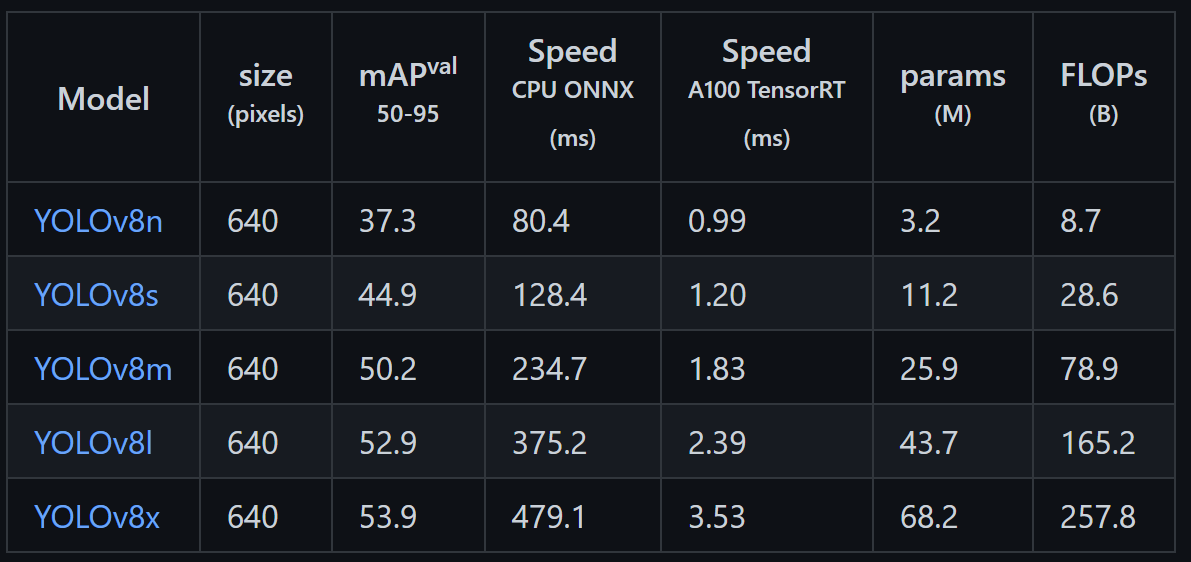

Create a new insatnce of a blank YOLOv8m model

In [6]:
model = YOLO('yolov8m.yaml')


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.Conv                  [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.Conv                  [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.C2f                   [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.Conv                  [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.C2f                   [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.Conv                  [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.C2f                   [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.Conv                  [384

### Train YOLOv8 Model

Train the model using the default parameters over 100 epochs.

In [7]:
model.train(data='/content/Debris-Detection-Dataset-1/data.yaml', seed=0,
            save_period=10,
            epochs=100)

Ultralytics YOLOv8.0.85 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/Debris-Detection-Dataset-1/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=

### Evaluate YOLOv8 Model

Evaluate the model with the validation dataset. The key metrics to look for here is the mAP50 and mAP50-95.

In [8]:
model = YOLO('/content/runs/detect/train/weights/best.pt')

In [9]:
model.val()

Ultralytics YOLOv8.0.85 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
YOLOv8m summary (fused): 218 layers, 25841497 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/Debris-Detection-Dataset-1/valid/labels.cache... 976 images, 0 backgrounds, 0 corrupt: 100%|██████████| 976/976 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/Debris-Detection-Dataset-1/valid/images/LAT-20Azerbaijan-202021-20-20Incident-201-20-Processed-20-4-mp4-t-14-333333_jpg.rf.799d5ad0a8be9fed3afd709d854cd174.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:10<00:00,  5.57it/s]
                   all        976       2548      0.886      0.844      0.877      0.583
                Debris        976       1398      0.776      0.631      0.694      0.304
               Marshal        976        959      0.924      0.931       0.96      0.654
      Recovery Vehicle        976        191    

ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f59a1c19790>
fitness: 0.6124083979245609
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.30382,     0.65357,     0.79162])
names: {0: 'Debris', 1: 'Marshal', 2: 'Recovery Vehicle'}
plot: True
results_dict: {'metrics/precision(B)': 0.8862053256035, 'metrics/recall(B)': 0.8435184685473661, 'metrics/mAP50(B)': 0.8770460582749378, 'metrics/mAP50-95(B)': 0.5830042134411858, 'fitness': 0.6124083979245609}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 0.31005236946168496, 'inference': 2.6059722314115428, 'loss': 0.0009128793341214539, 'postprocess': 1.0155014327315035}

Lets have a look at the confusion matrix to how the model performs for each class.

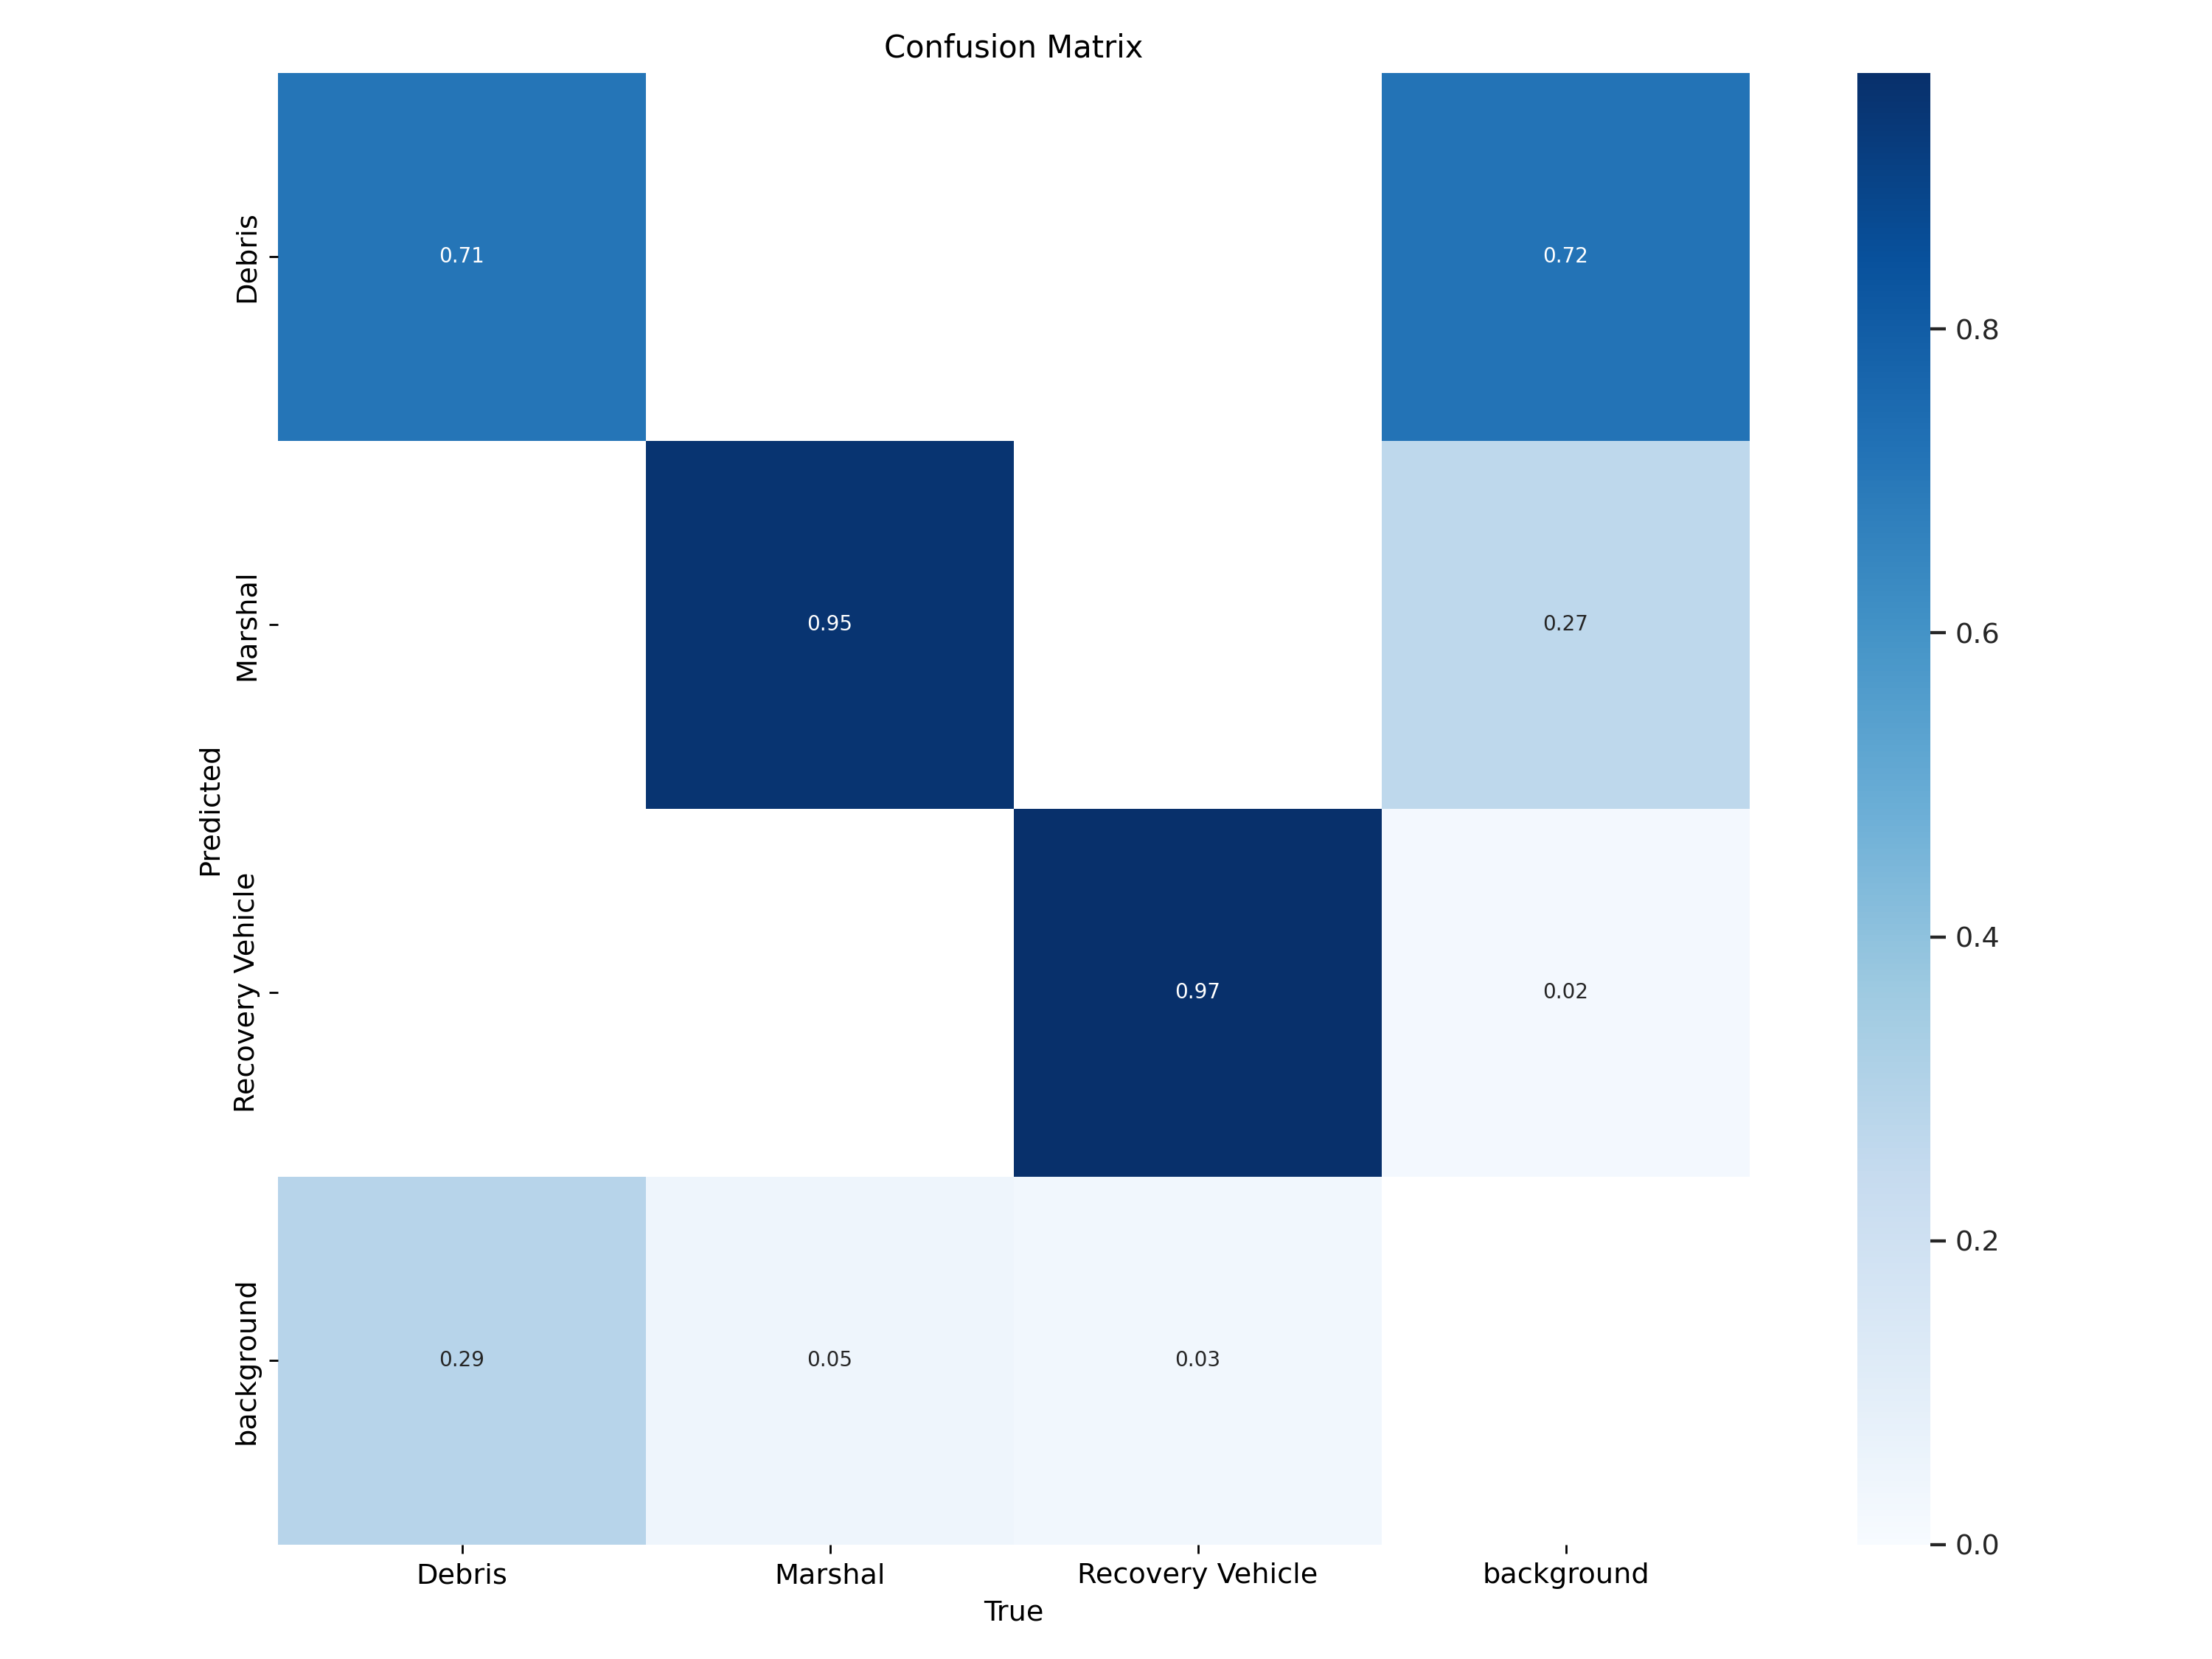

In [10]:
Image('/content/runs/detect/val/confusion_matrix.png', width=600)

Here it appears that model performs very well. The confusion matrix highlights some particular confusion that the model experiences between debris and the background.

Lets check is there was any room for improvement after 100 epochs? If the various loss lines start to flatten out the model has more or less reached its maximum accuracy given the hyperparameters fed to it. 

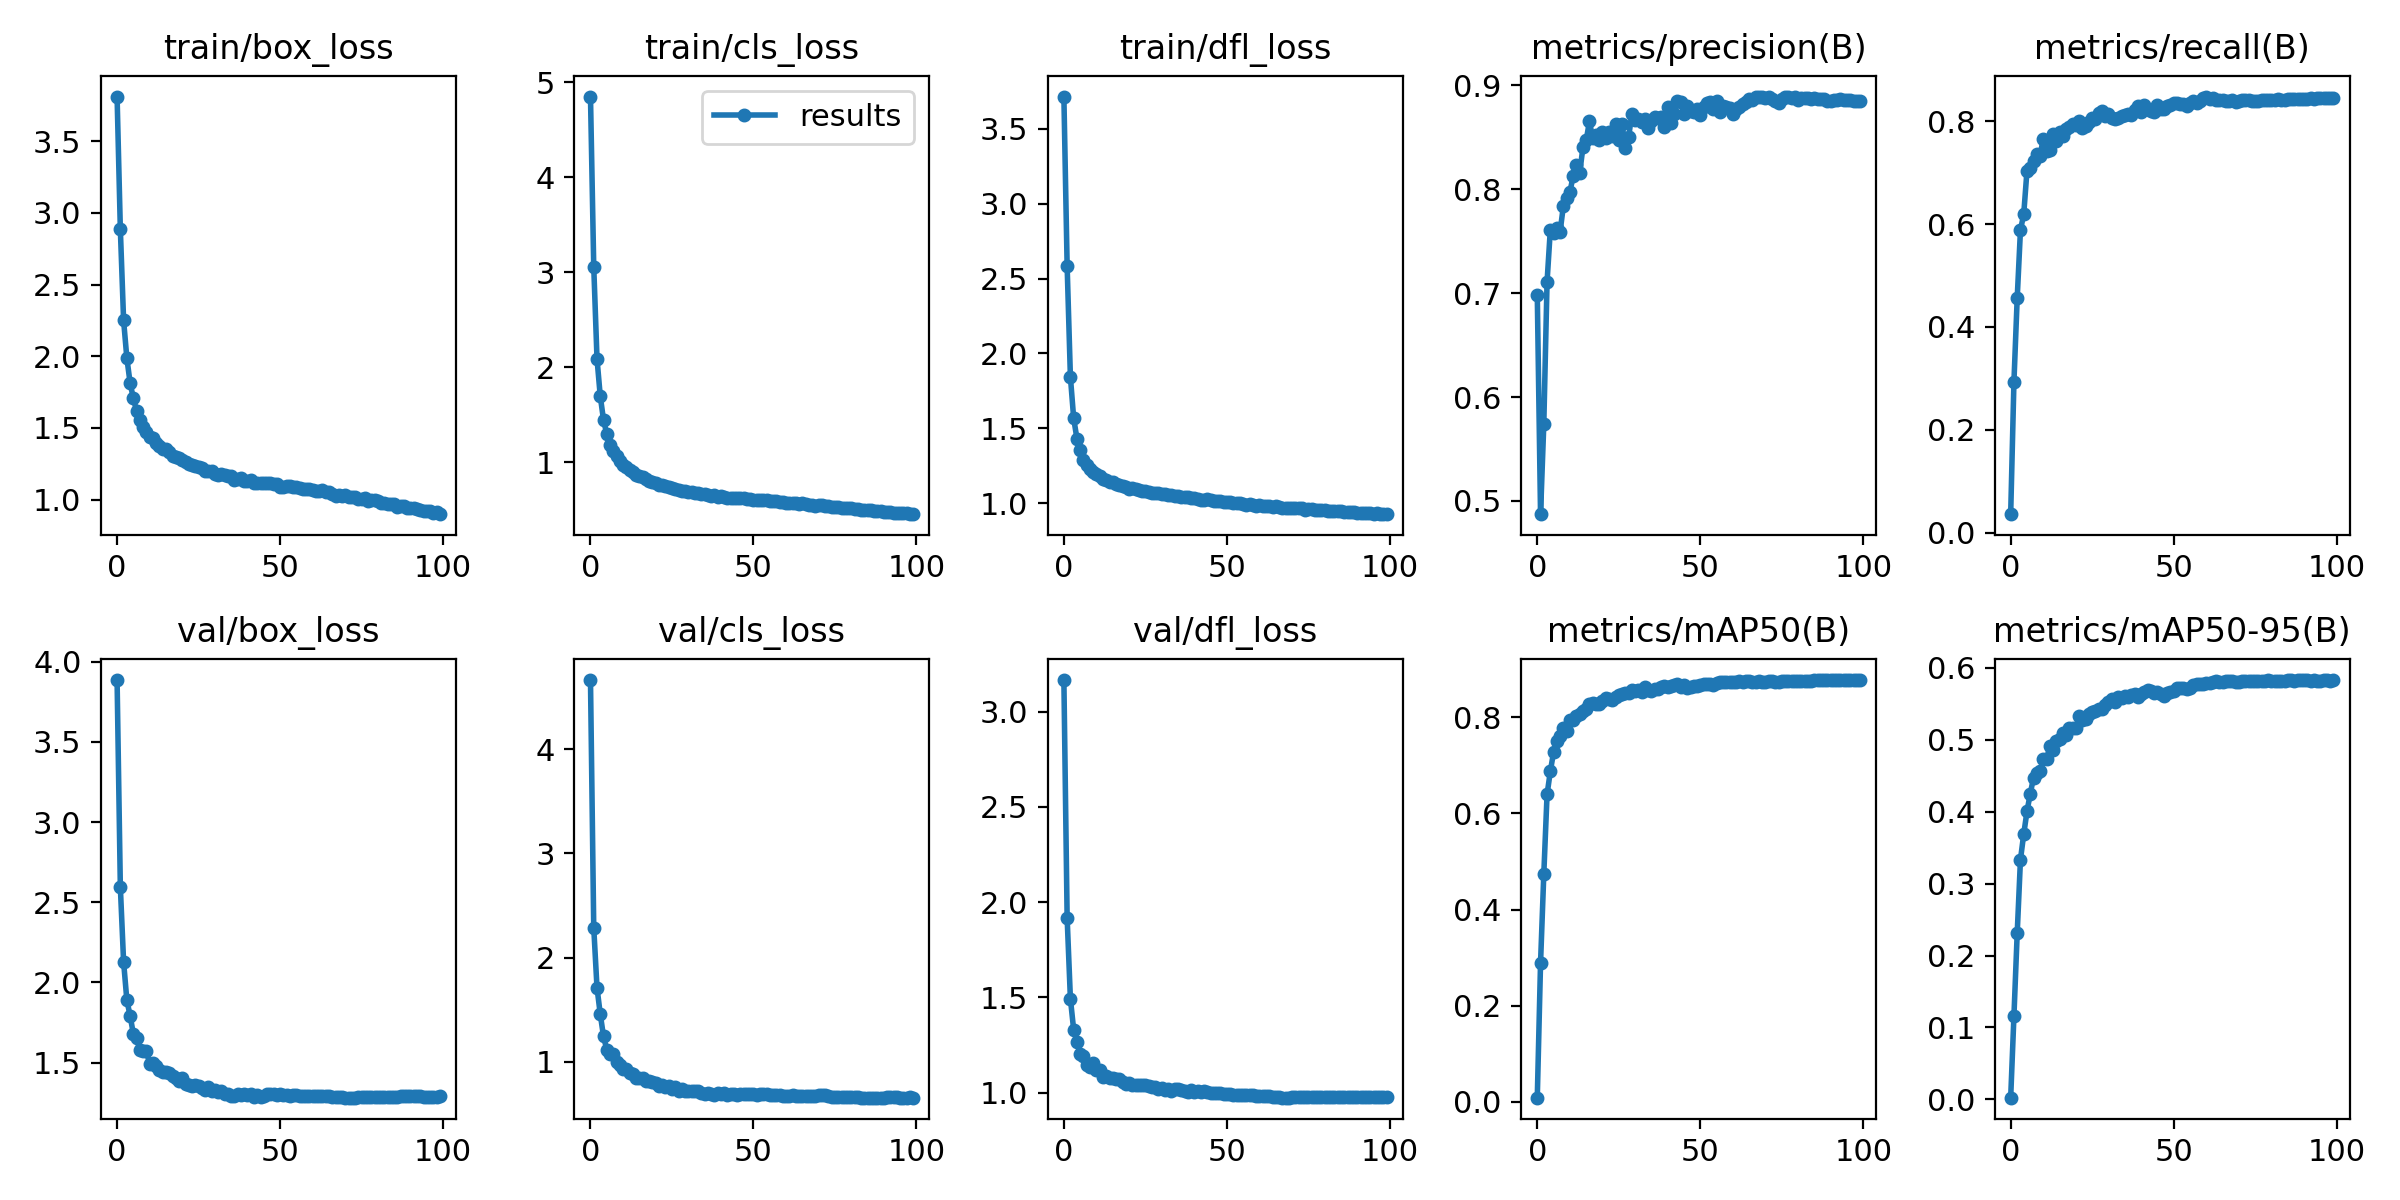

In [11]:
Image('/content/runs/detect/train/results.png', width=600)

### Validate YOLOv8 Model

To further demonstrate the performance of the YOLOv8m model, below is two batches of the same 16 images. 
- The first collection of images represents the model's predictions
- The second colelction of images represents the corresponding ground truth (my annotations using vott)

Lets see how the two compare?

Model Predictions

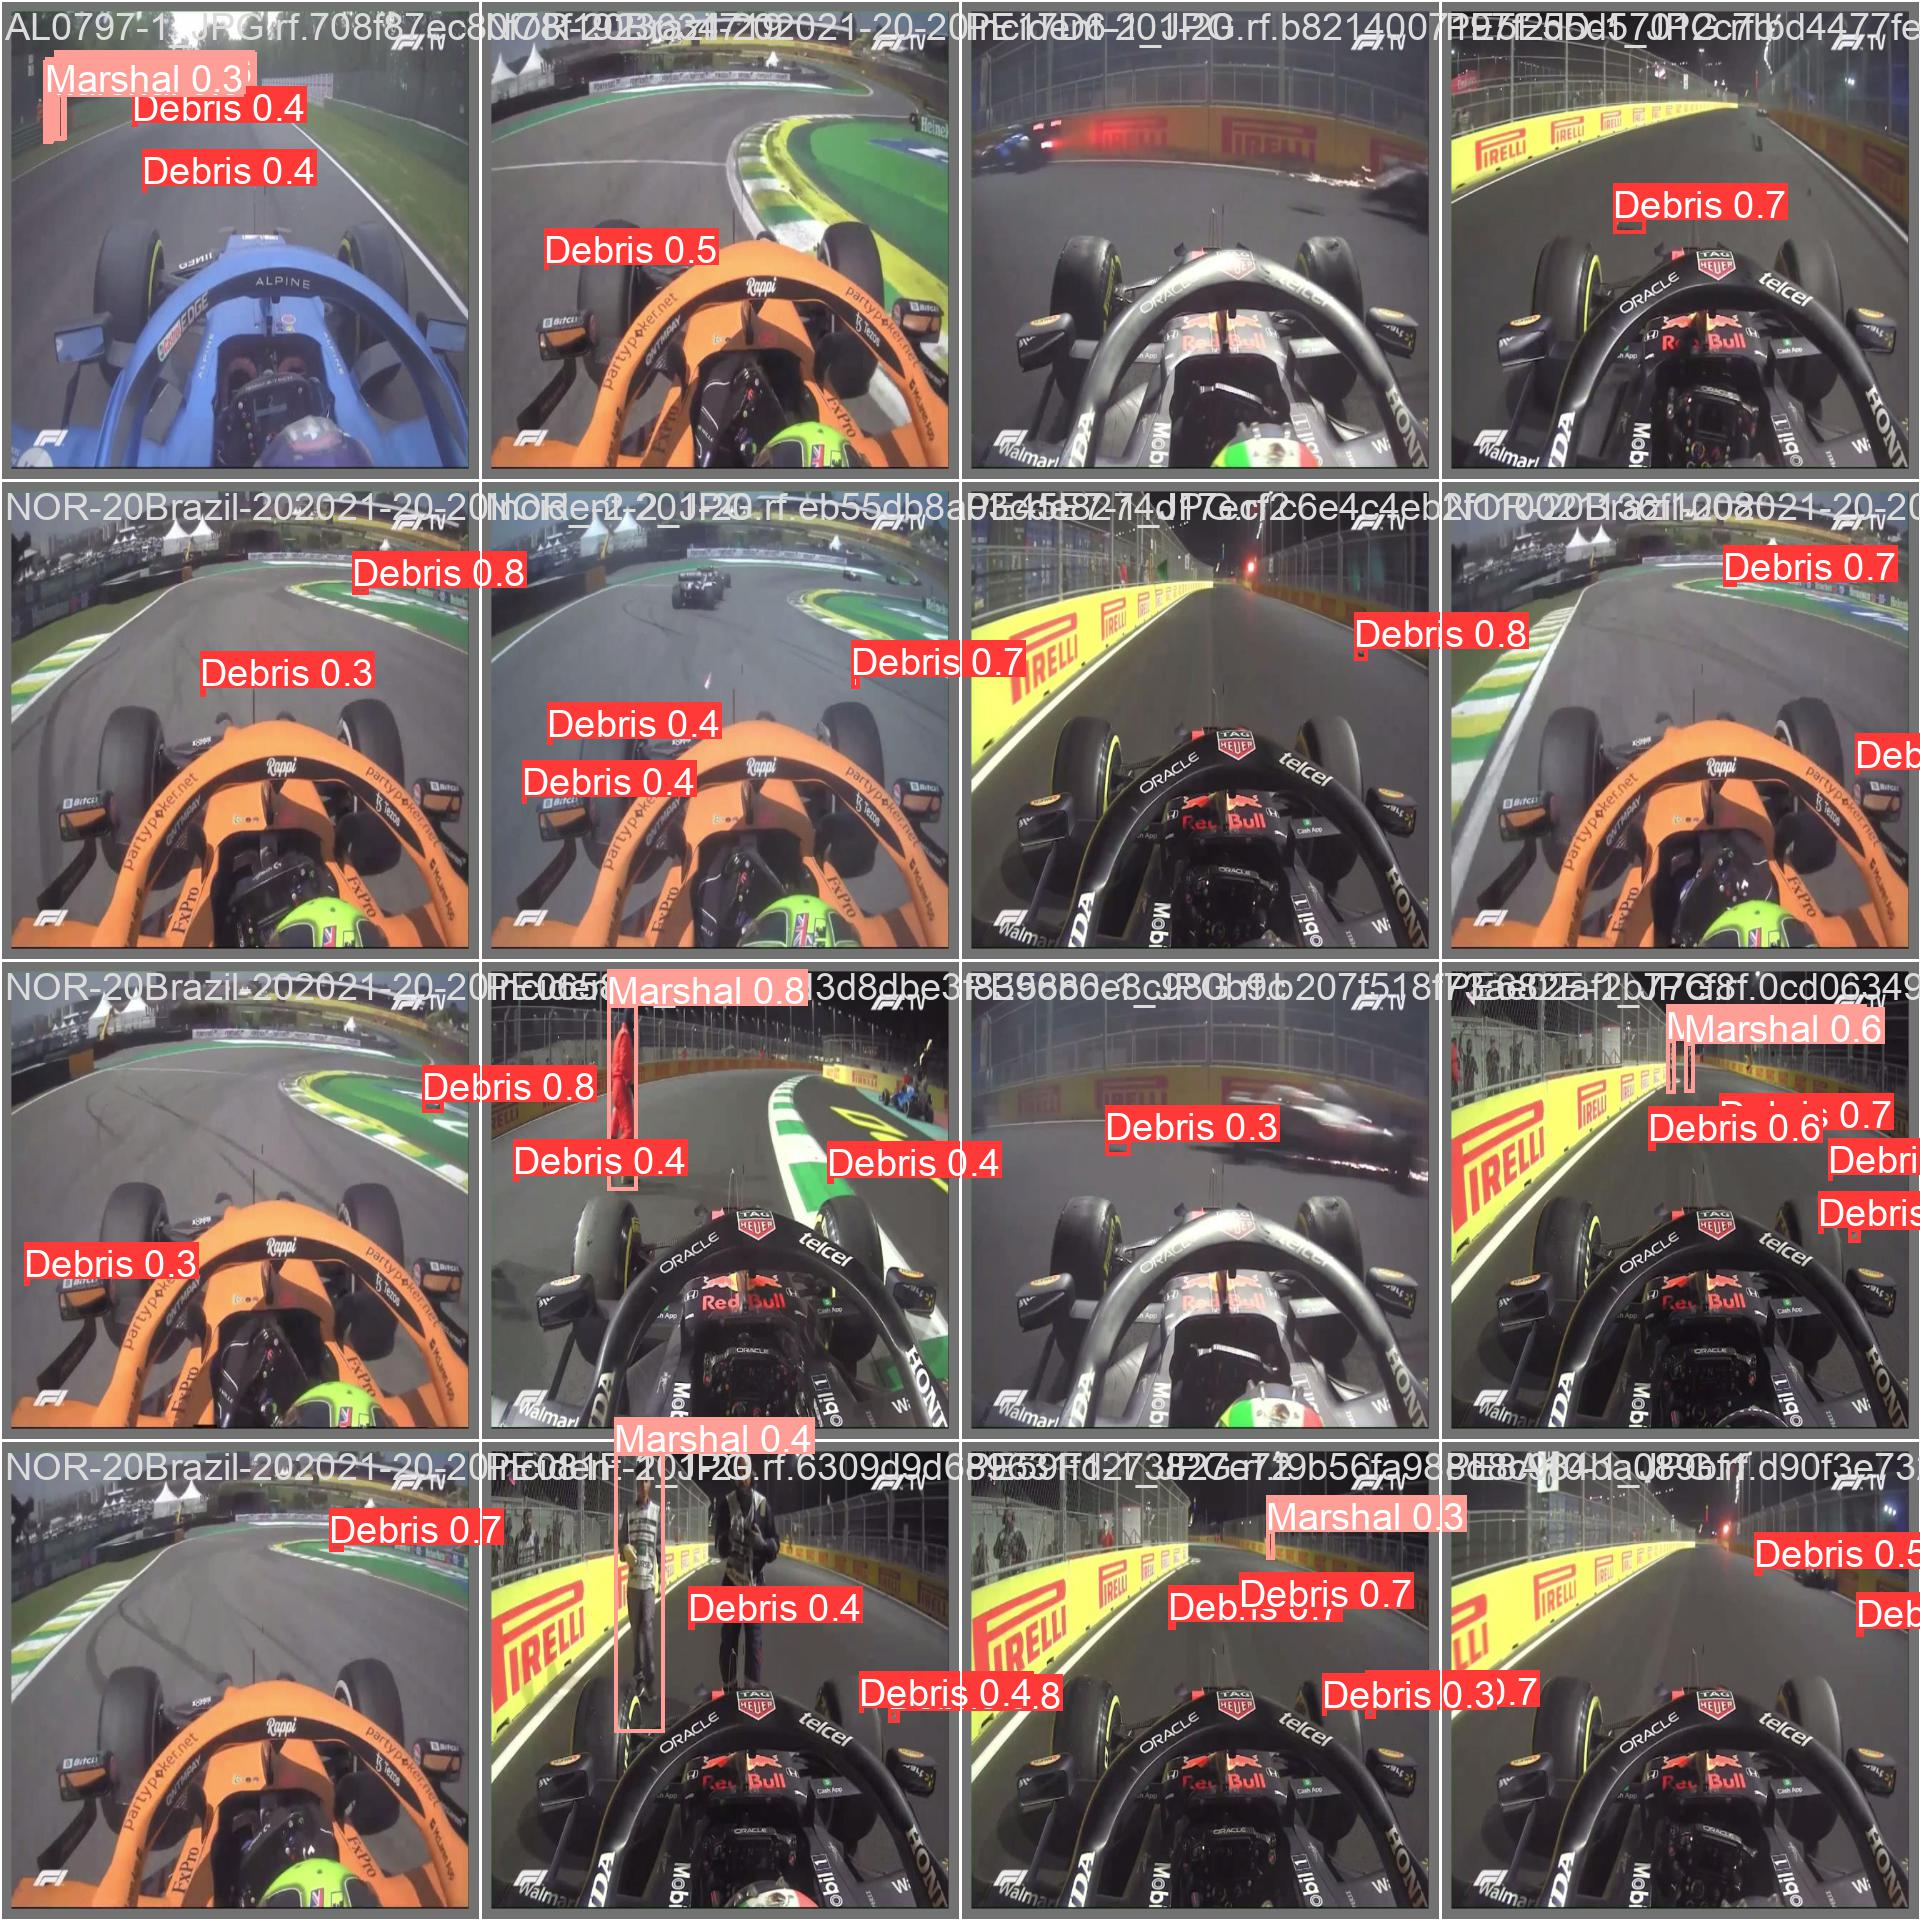

In [12]:
Image('/content/runs/detect/val/val_batch0_pred.jpg', width=600)

Ground Truth

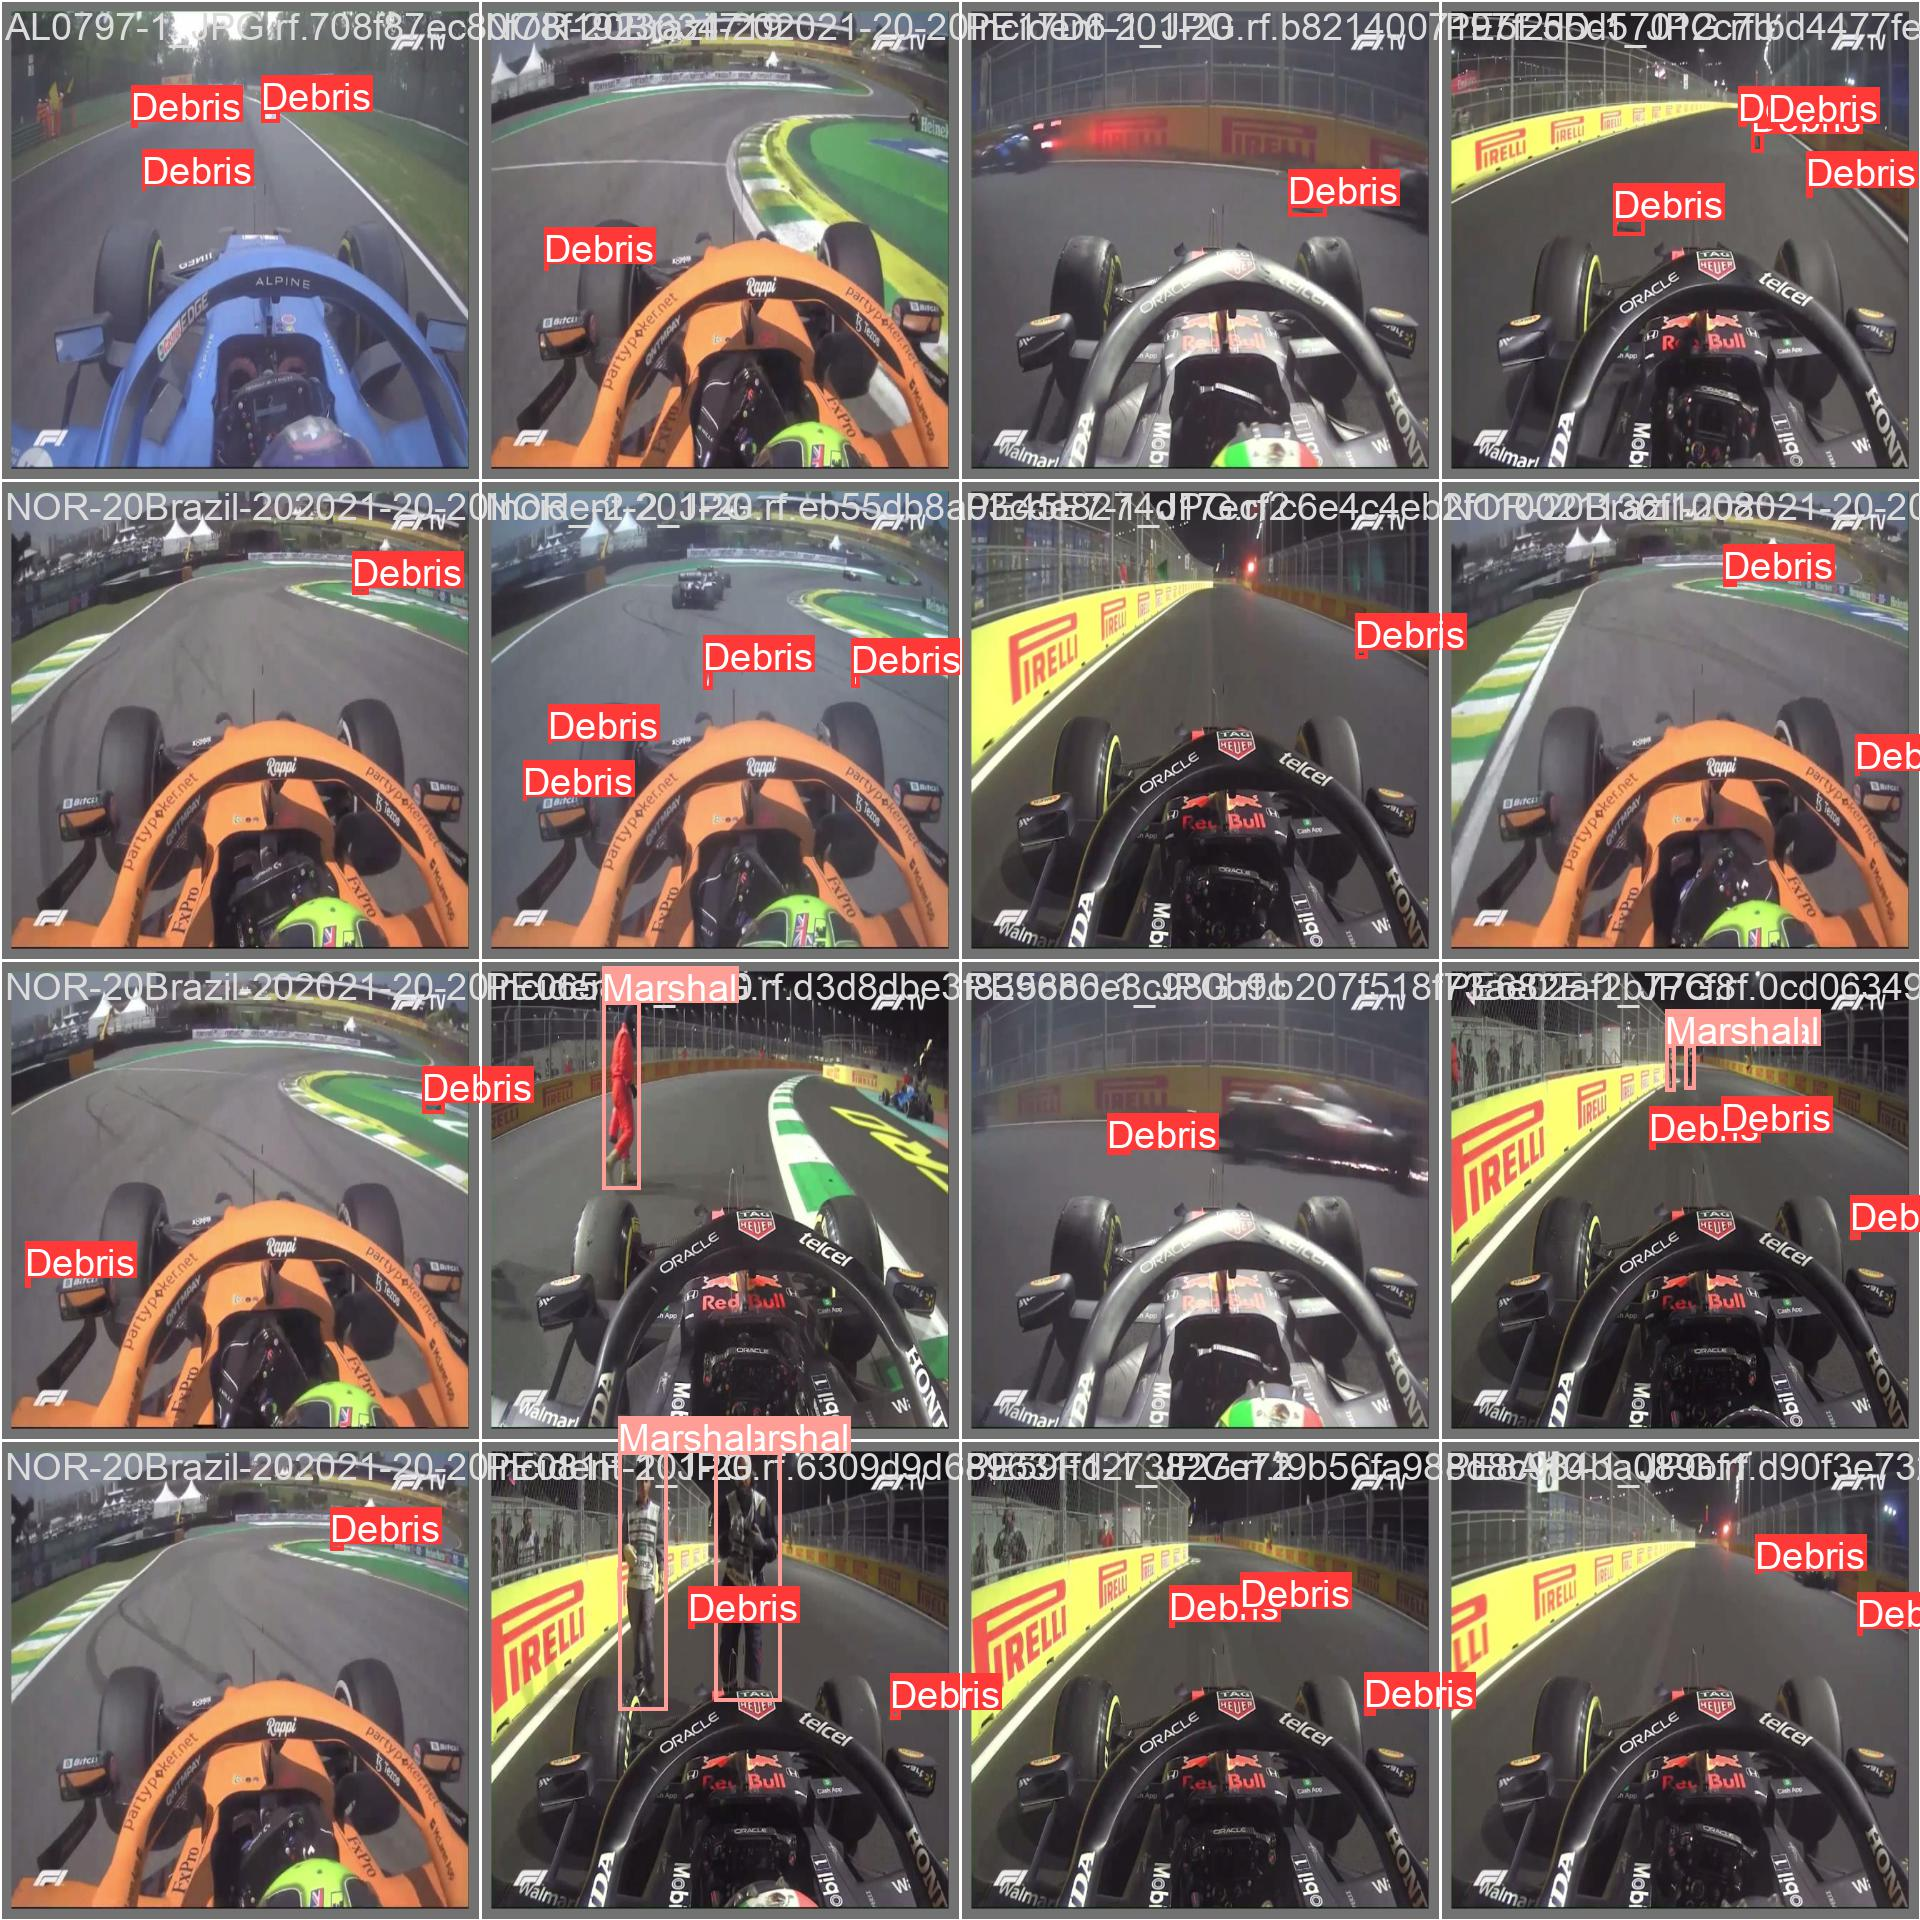

In [13]:
Image('/content/runs/detect/val/val_batch0_labels.jpg', width=600)

Inference Example

Let's now run inference on a random image the model has not seen before (from the validation dataset) and display the original image (with no annotations) and the model's prediction(s).

Original Image


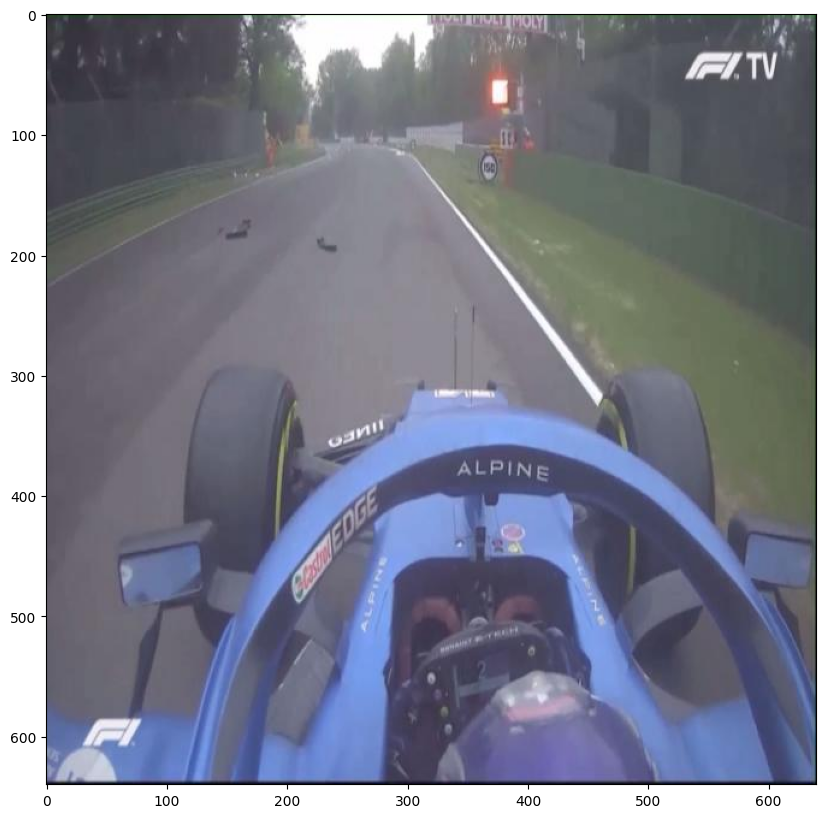


0: 640x640 3 Debriss, 11.0ms
Speed: 0.6ms preprocess, 11.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


Predictions


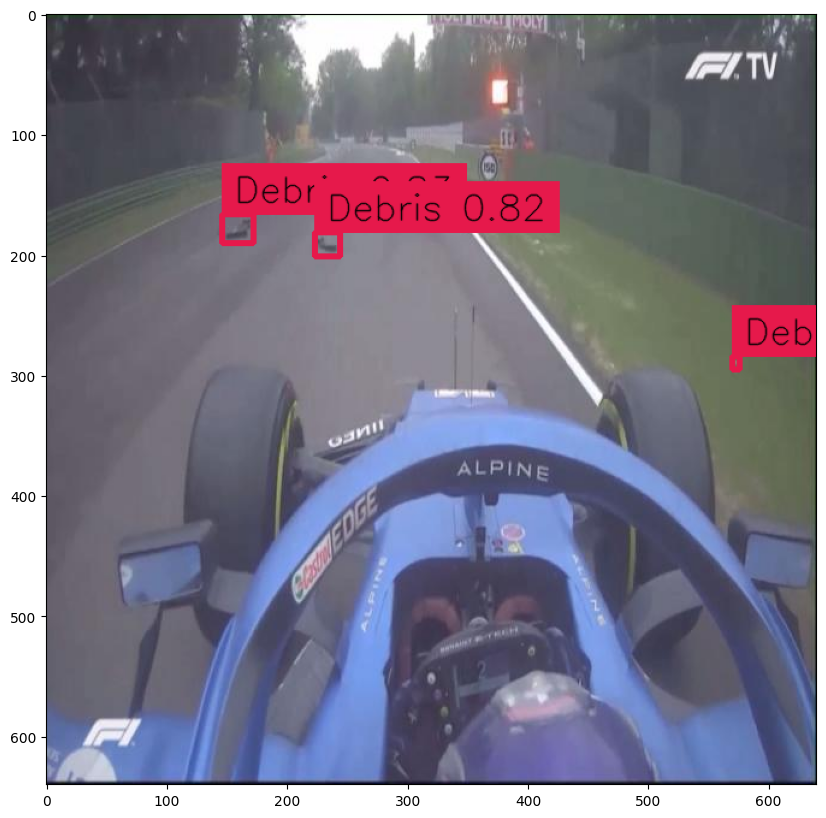

In [14]:
CLASS_NAMES_DICT = model.model.names
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.5

# Select random image from validation dataset
dir = "/content/Debris-Detection-Dataset-1/valid/images"
image_path = os.path.join(dir, random.choice(os.listdir(dir)))
image = cv2.imread(image_path)

# Display the selected random image
print('Original Image')
%matplotlib inline  
sv.show_frame_in_notebook(image, (10, 10))

# Tool used to annotate objects
box_annotator = BoxAnnotator(color=ColorPalette.from_hex(['#e6194b', '#ffe119', '#66cccc']), thickness=4, text_thickness=1, text_scale=1)

# Make predictions
results = model(image, iou=IOU_TRESHOLD, conf=CONFIDENCE_TRESHOLD)

# Extract predictions 
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

# Format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]

# Annotate the frame with the models detections
image = box_annotator.annotate(image, detections=detections, labels=labels)

# Display image with the models detections
print('Predictions')
%matplotlib inline  
sv.show_frame_in_notebook(image, (10, 10))

### Hyperparameter Search

Import small training test

In [15]:
rf = Roboflow(api_key="BiTnmg5zTkGJyeI4pE1w")
project = rf.workspace("will-newbould-nnxbu").project("debris-detection-hyperparameter-training")
dataset = project.version(2).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.85, to fix: `pip install ultralytics<=8.0.20`


Extracting Dataset Version Zip to Debris-Detection-Hyperparameter-Training-2 in yolov8:: 100%|██████████| 4008/4008 [00:00<00:00, 7048.33it/s]


See what the performance of the base hyperparameter are on the small dataset to create a performance benchmark.

In [16]:
model_base = YOLO('yolov8m.yaml')

model_base.train(data='/content/Debris-Detection-Hyperparameter-Training-2/data.yaml', seed=0, epochs=20)


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.Conv                  [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.Conv                  [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.C2f                   [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.Conv                  [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.C2f                   [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.Conv                  [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.C2f                   [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.Conv                  [384

Use Optuna to trial a range of different hyperparameters with the aim of finding the trial with the highest mAP50 and mAP50-95 after 20 epochs. 

In [17]:
def objective(trial):
    # Categorical parameter
    optimizer = trial.suggest_categorical("optimizer", ["SGD", "Adam"])

    # Integer parameter (discretized)
    batch = trial.suggest_int("batch", 8, 32, step=4)

    # Floating point parameter (log)
    learning_rate_0 = trial.suggest_float("learning_rate_0", 1e-5, 1e-1, log=True)

    # Floating point parameter (log)
    learning_rate_final = trial.suggest_float("learning_rate_final", 1e-5, 1e-2, log=True)

    model_finetuned = YOLO('yolov8m.yaml')

    model_finetuned.train(data='/content/Debris-Detection-Hyperparameter-Training-2/data.yaml', seed=0,
                          epochs=20,
                          optimizer=optimizer,
                          batch=batch,
                          lr0=learning_rate_0,
                          lrf=learning_rate_final)
    
    metrics = model_finetuned.val()
    map50 = metrics.box.map50
    map50_95 = metrics.box.map

    return map50, map50_95

# Number of trials
n_trials = 20

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(objective, n_trials=n_trials)

[I 2023-04-23 15:52:42,722] A new study created in memory with name: no-name-cc91e92d-e7c4-4601-9647-feb6601839db

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.Conv                  [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.Conv                  [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.C2f                   [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.Conv                  [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.C2f                   [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.Conv                  [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.C2f                   [384

In [18]:
# Report the best performing trial with the combined highest mAP50 score after 10 epochs
# Note lambda t: t.values[0] refers to the mAP50 metric score and lambda t: t.values[1] refers to the mAP50-95 metric score
print(f"\nNumber of trials: {len(study.best_trials)}")
print(f"Trial with highest mAP50: ")
best_trial = max(study.best_trials, key=lambda t: t.values[0])
print(f"\ttrial number: {best_trial.number}")
print(f"\tparameters: {best_trial.params}")
print(f"\tmAP50: {best_trial.values[0]}")
print(f"\tmAP50_95: {best_trial.values[1]}")


Number of trials: 1
Trial with highest mAP50: 
	trial number: 18
	parameters: {'optimizer': 'Adam', 'batch': 12, 'learning_rate_0': 0.00032128697487128493, 'learning_rate_final': 0.0012768561018711455}
	mAP50: 0.5959794558321324
	mAP50_95: 0.3340495398843452


#### Trial History

Plot the mAP50 and mAP50-95 performance of the various trials

In [19]:
plot_optimization_history(study, target=lambda t: t.values[0], target_name='mAP50')

In [20]:
plot_optimization_history(study, target=lambda t: t.values[1], target_name='mAP50-95')

Plot the mAP50 and mAp50-95 performance of the various trials on the same plot. 

In [21]:
optuna.visualization.plot_pareto_front(study, target_names=['mAP50', 'mAP50-95'])

#### Slice Plot

Plot the various trialed hyperparameters and the corresponding mAP50 and mAP50-95 metrics

In [22]:
plot_slice(study, target=lambda t: t.values[0], target_name='map50')

In [23]:
plot_slice(study, target=lambda t: t.values[1], target_name='map50-95')

#### Hyperparameter Importance

Plot each hyperparameter's importance relating to both the mAP50 and mAP50-95 metrics.

In [24]:
plot_param_importances(study, target=lambda t: t.values[0], target_name='mAP50')

In [25]:
plot_param_importances(study, target=lambda t: t.values[1], target_name='mAP50-95')

#### Re-use best trial to re-train model

Let's now train a blank YOLOv8 model using the hyperparameters from the best trial and see if it outperforms the initial model using the default hyperparameters.

In [26]:
# Best trial's optimizer
optimizer = best_trial.params['optimizer']

# Best trial's batch size
batch = best_trial.params['batch']

# Best trial's initial learning rate
learning_rate_0 = best_trial.params['learning_rate_0']

# Best trial's final learning rate
learning_rate_final = best_trial.params['learning_rate_final']

# Train model with optimised hyperparameters
model_finetuned = YOLO('yolov8m.yaml')

model_finetuned.train(data='/content/Debris-Detection-Dataset-1/data.yaml', seed=0,
                       save_period=10,
                        epochs=100,
                        optimizer=optimizer,
                        batch=batch,
                        lr0=learning_rate_0,
                        lrf=learning_rate_final)


                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.Conv                  [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.Conv                  [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.C2f                   [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.Conv                  [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.C2f                   [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.Conv                  [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.C2f                   [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics.nn.modules.Conv                  [384

##### Evaluiate Model

In [37]:
model_finetuned.val()

Ultralytics YOLOv8.0.85 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
val: Scanning /content/Debris-Detection-Dataset-1/valid/labels.cache... 976 images, 0 backgrounds, 0 corrupt: 100%|██████████| 976/976 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/Debris-Detection-Dataset-1/valid/images/LAT-20Azerbaijan-202021-20-20Incident-201-20-Processed-20-4-mp4-t-14-333333_jpg.rf.799d5ad0a8be9fed3afd709d854cd174.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:10<00:00,  7.64it/s]
                   all        976       2548      0.875      0.833      0.875      0.582
                Debris        976       1398      0.771      0.609      0.686      0.299
               Marshal        976        959      0.917      0.926      0.959      0.655
      Recovery Vehicle        976        191      0.937      0.963       0.98      0.793
Speed: 0.3ms preprocess, 2.6ms inference, 

ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f58cf591af0>
fitness: 0.6115732019180852
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.29929,     0.65471,     0.79301])
names: {0: 'Debris', 1: 'Marshal', 2: 'Recovery Vehicle'}
plot: True
results_dict: {'metrics/precision(B)': 0.8748538833924178, 'metrics/recall(B)': 0.8326599698063334, 'metrics/mAP50(B)': 0.874730646673072, 'metrics/mAP50-95(B)': 0.5823334858341978, 'fitness': 0.6115732019180852}
save_dir: PosixPath('runs/detect/val27')
speed: {'preprocess': 0.2801611286694886, 'inference': 2.5786862510149593, 'loss': 0.0011749932023345446, 'postprocess': 0.9887555583578641}

In [39]:
# Report the target performance of initial model
print('\nBenchmark from base model after 100 epochs is: ')
print(f"\tmAP50: {model.val().box.map50}")
print(f"\tmAP50-95:  {model.val().box.map}")

# Report the target performance of finetuned model
print('\nBenchmark from finetuned model after 100 epochs is: ')
print(f"\tmAP50: {model_finetuned.val().box.map50}")
print(f"\tmAP50-95:  {model_finetuned.val().box.map}")

Ultralytics YOLOv8.0.85 🚀 Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)



Benchmark from base model after 100 epochs is: 


val: Scanning /content/Debris-Detection-Dataset-1/valid/labels.cache... 976 images, 0 backgrounds, 0 corrupt: 100%|██████████| 976/976 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/Debris-Detection-Dataset-1/valid/images/LAT-20Azerbaijan-202021-20-20Incident-201-20-Processed-20-4-mp4-t-14-333333_jpg.rf.799d5ad0a8be9fed3afd709d854cd174.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:11<00:00,  5.30it/s]
                   all        976       2548      0.886      0.844      0.877      0.583
                Debris        976       1398      0.776      0.631      0.694      0.304
               Marshal        976        959      0.924      0.931       0.96      0.654
      Recovery Vehicle        976        191      0.958      0.969      0.978      0.792
Speed: 0.3ms preprocess, 2.5ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val32
Ultralytics YOLOv8.0.85 

	mAP50: 0.8770460582749378


val: Scanning /content/Debris-Detection-Dataset-1/valid/labels.cache... 976 images, 0 backgrounds, 0 corrupt: 100%|██████████| 976/976 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/Debris-Detection-Dataset-1/valid/images/LAT-20Azerbaijan-202021-20-20Incident-201-20-Processed-20-4-mp4-t-14-333333_jpg.rf.799d5ad0a8be9fed3afd709d854cd174.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 61/61 [00:13<00:00,  4.44it/s]
                   all        976       2548      0.886      0.844      0.877      0.583
                Debris        976       1398      0.776      0.631      0.694      0.304
               Marshal        976        959      0.924      0.931       0.96      0.654
      Recovery Vehicle        976        191      0.958      0.969      0.978      0.792
Speed: 0.4ms preprocess, 2.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val33
Ultralytics YOLOv8.0.85 

	mAP50-95:  0.5830042134411858

Benchmark from finetuned model after 100 epochs is: 


val: Scanning /content/Debris-Detection-Dataset-1/valid/labels.cache... 976 images, 0 backgrounds, 0 corrupt: 100%|██████████| 976/976 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/Debris-Detection-Dataset-1/valid/images/LAT-20Azerbaijan-202021-20-20Incident-201-20-Processed-20-4-mp4-t-14-333333_jpg.rf.799d5ad0a8be9fed3afd709d854cd174.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:10<00:00,  7.50it/s]
                   all        976       2548      0.875      0.833      0.875      0.582
                Debris        976       1398      0.771      0.609      0.686      0.299
               Marshal        976        959      0.917      0.926      0.959      0.655
      Recovery Vehicle        976        191      0.937      0.963       0.98      0.793
Speed: 0.3ms preprocess, 2.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val34
Ultralytics YOLOv8.0.85 

	mAP50: 0.874730646673072


val: Scanning /content/Debris-Detection-Dataset-1/valid/labels.cache... 976 images, 0 backgrounds, 0 corrupt: 100%|██████████| 976/976 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/Debris-Detection-Dataset-1/valid/images/LAT-20Azerbaijan-202021-20-20Incident-201-20-Processed-20-4-mp4-t-14-333333_jpg.rf.799d5ad0a8be9fed3afd709d854cd174.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 82/82 [00:10<00:00,  7.50it/s]
                   all        976       2548      0.875      0.833      0.875      0.582
                Debris        976       1398      0.771      0.609      0.686      0.299
               Marshal        976        959      0.917      0.926      0.959      0.655
      Recovery Vehicle        976        191      0.937      0.963       0.98      0.793
Speed: 0.4ms preprocess, 2.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val35


	mAP50-95:  0.5823334858341978


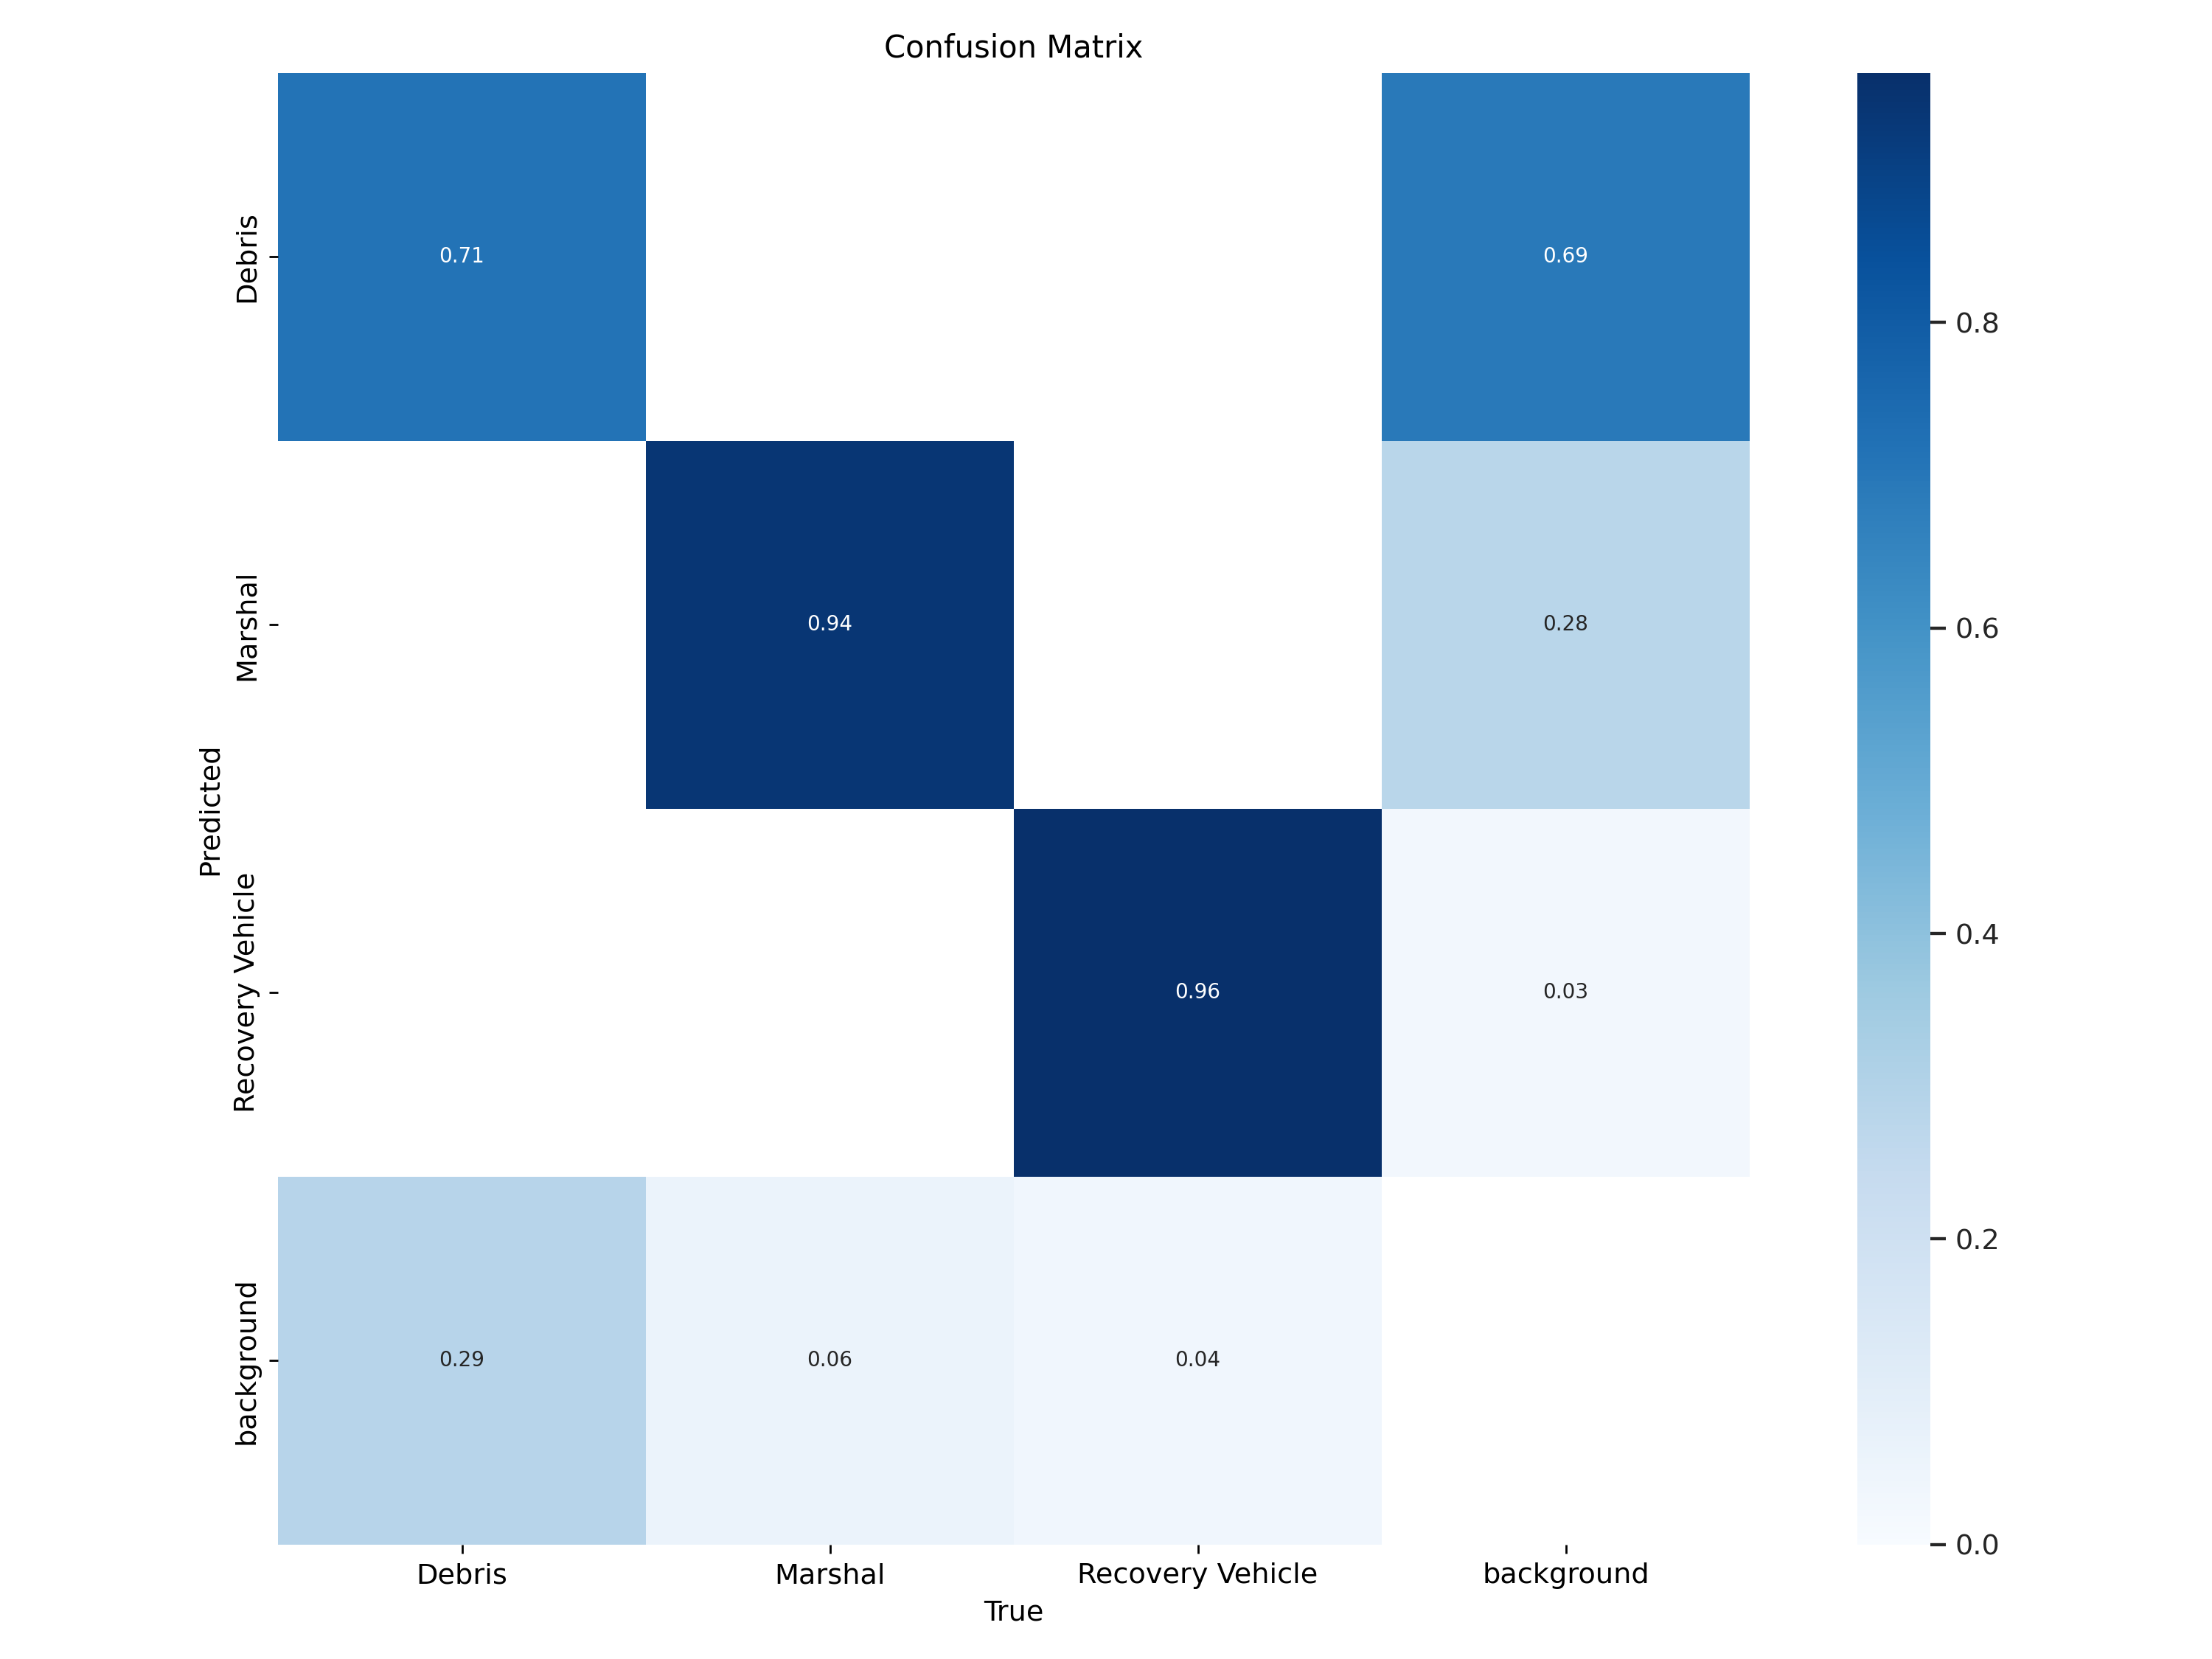

In [40]:
Image('/content/runs/detect/train' + str(n_trials+3) + '/confusion_matrix.png', width=600)

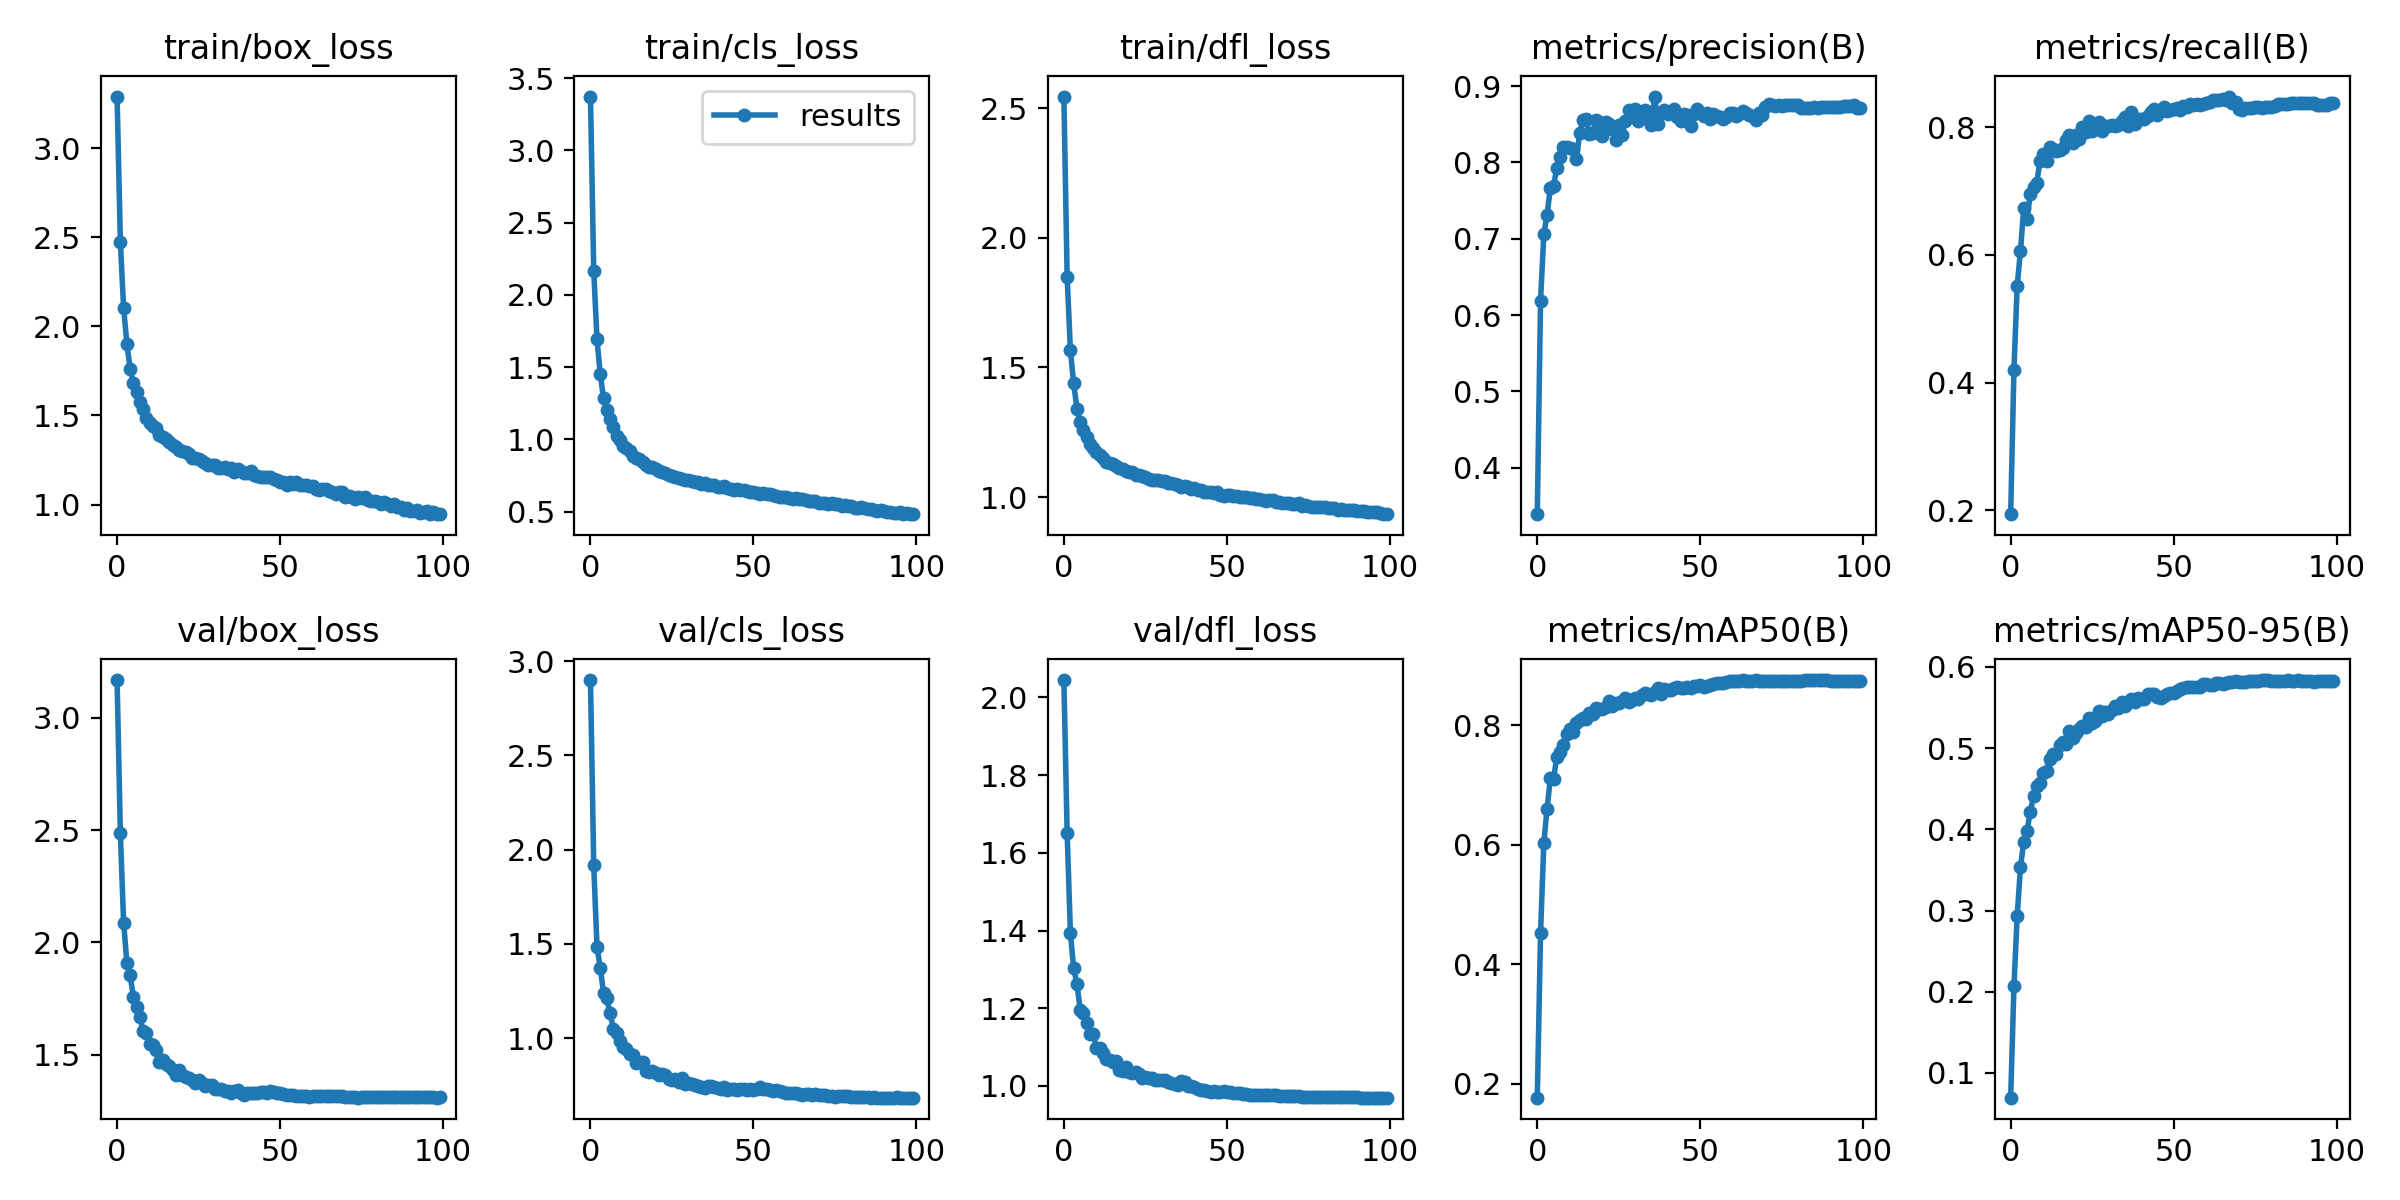

In [41]:
Image('/content/runs/detect/train' + str(n_trials+3) + '/results.png', width=600)

##### Validate Model

Model Predictions

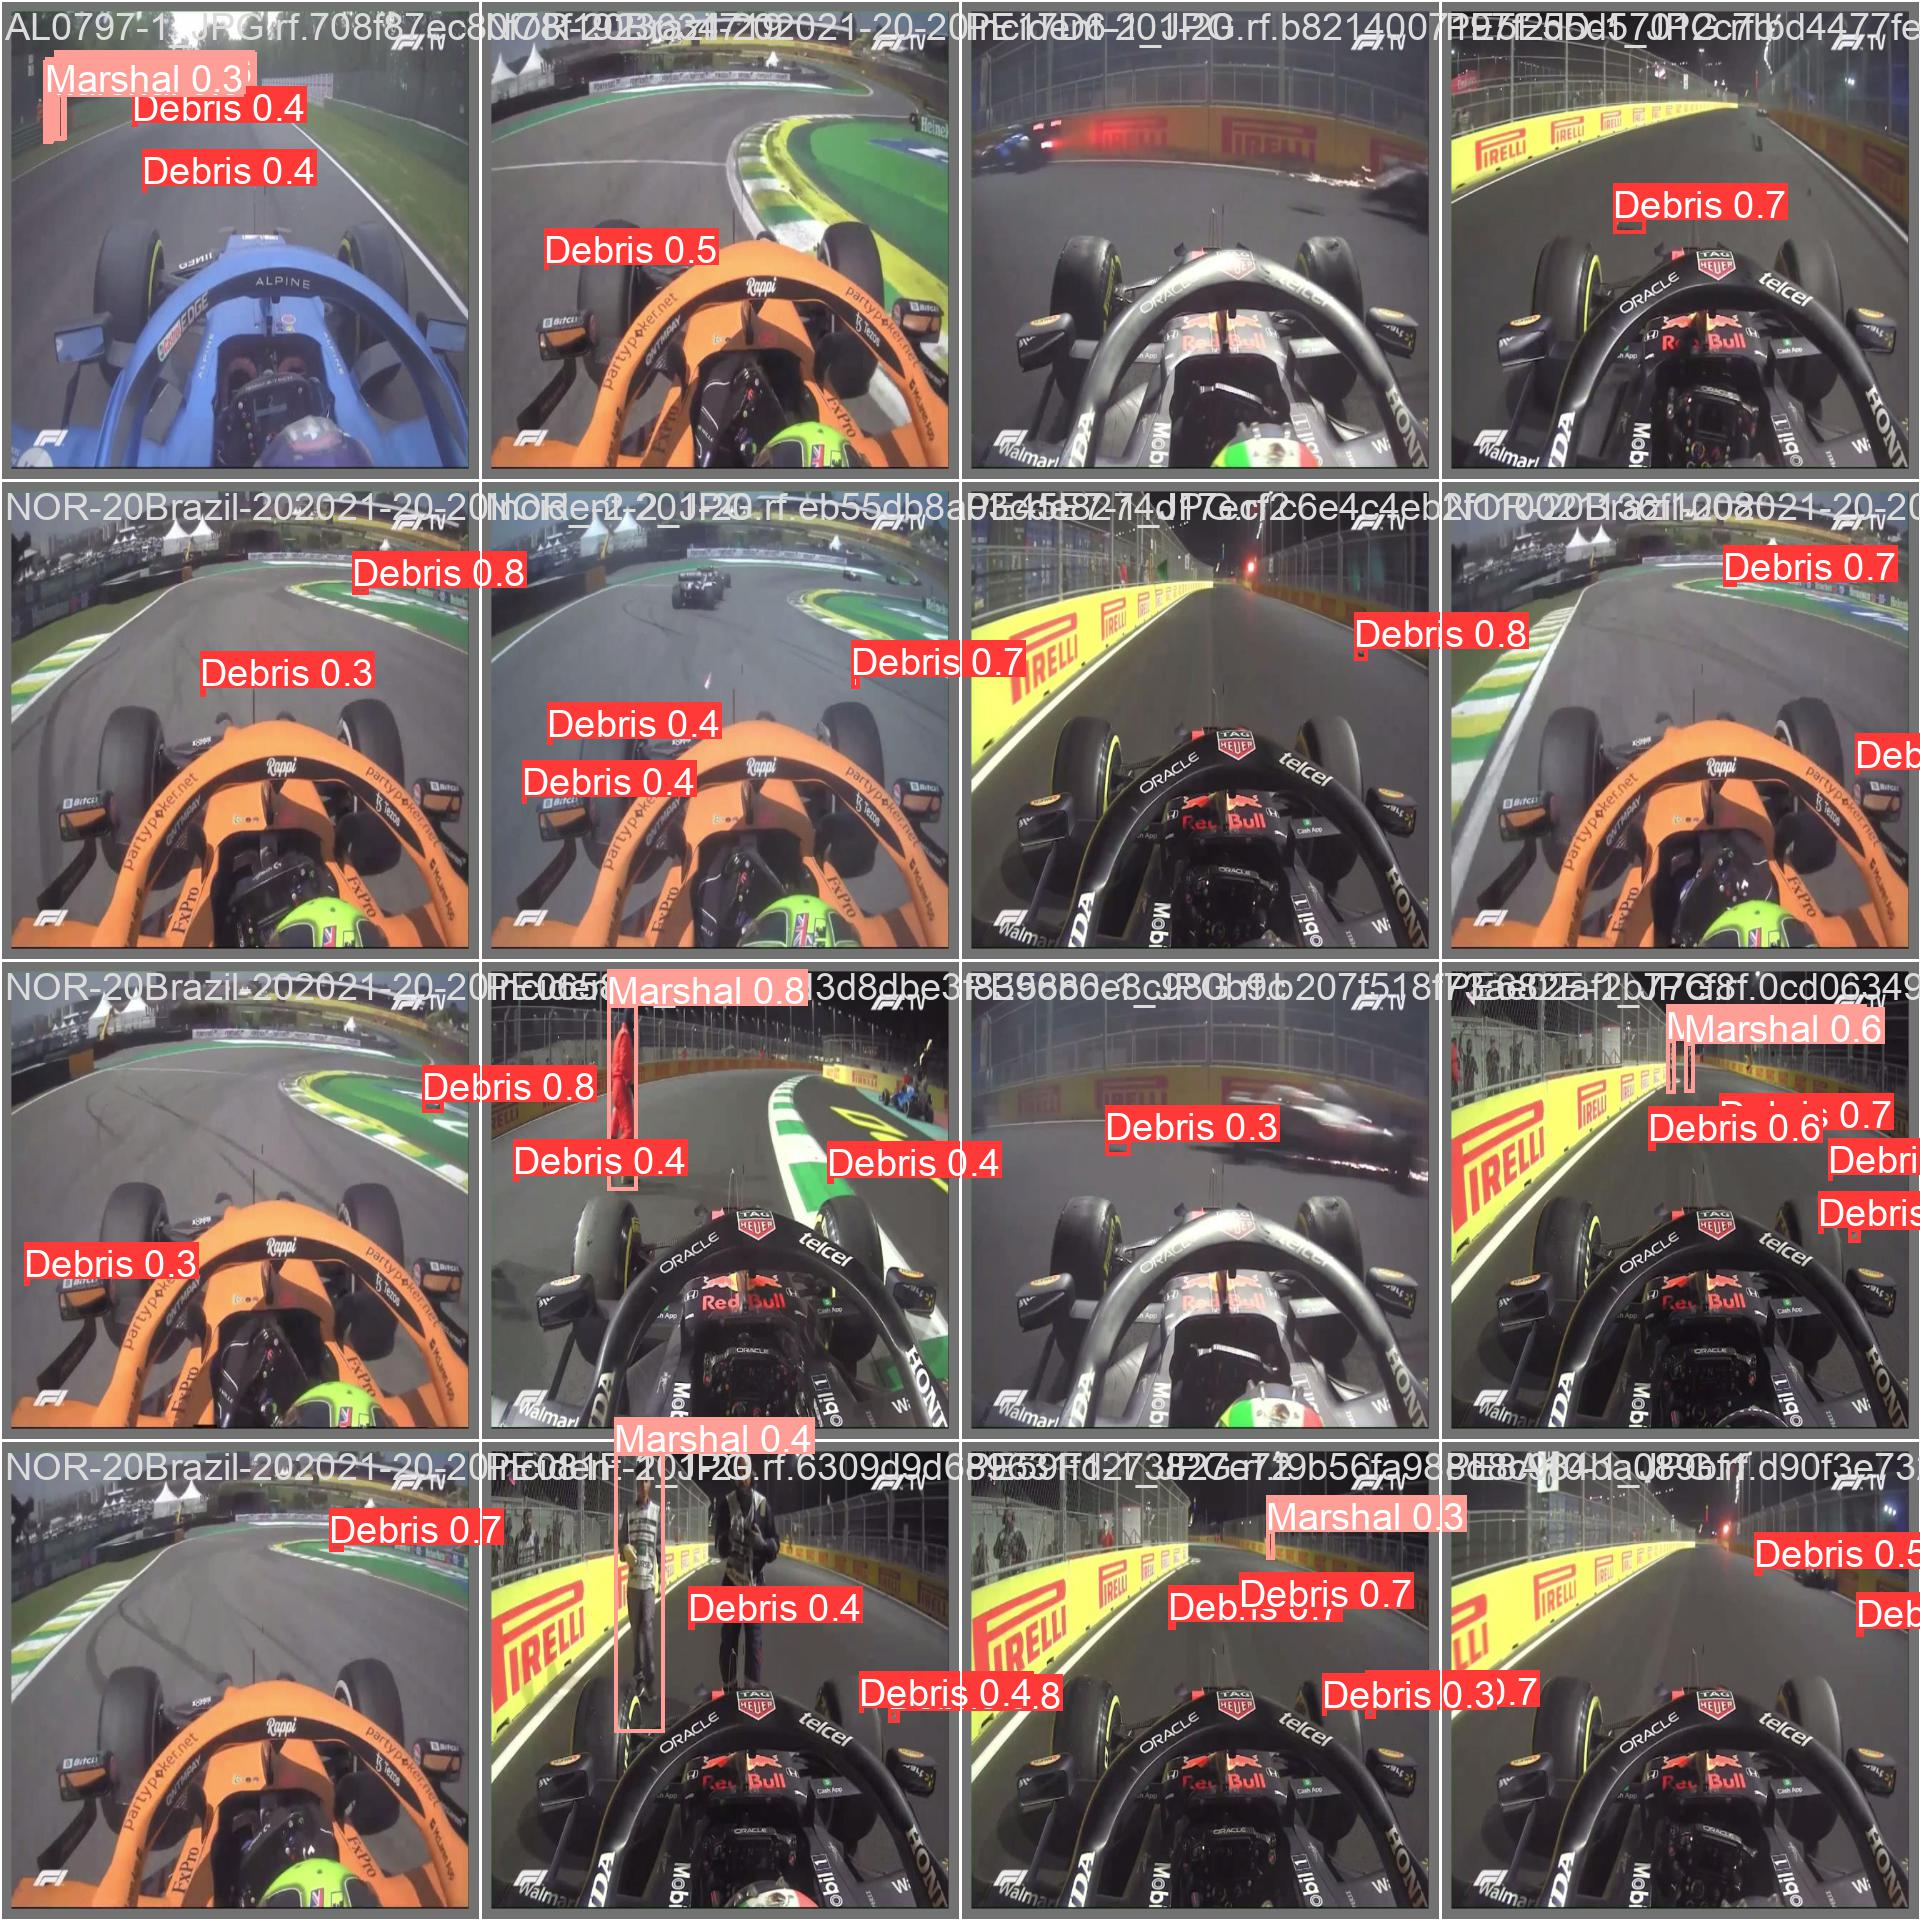

In [42]:
Image('/content/runs/detect/val' + str(n_trials+3) + '/val_batch0_pred.jpg', width=600)

Ground Truth

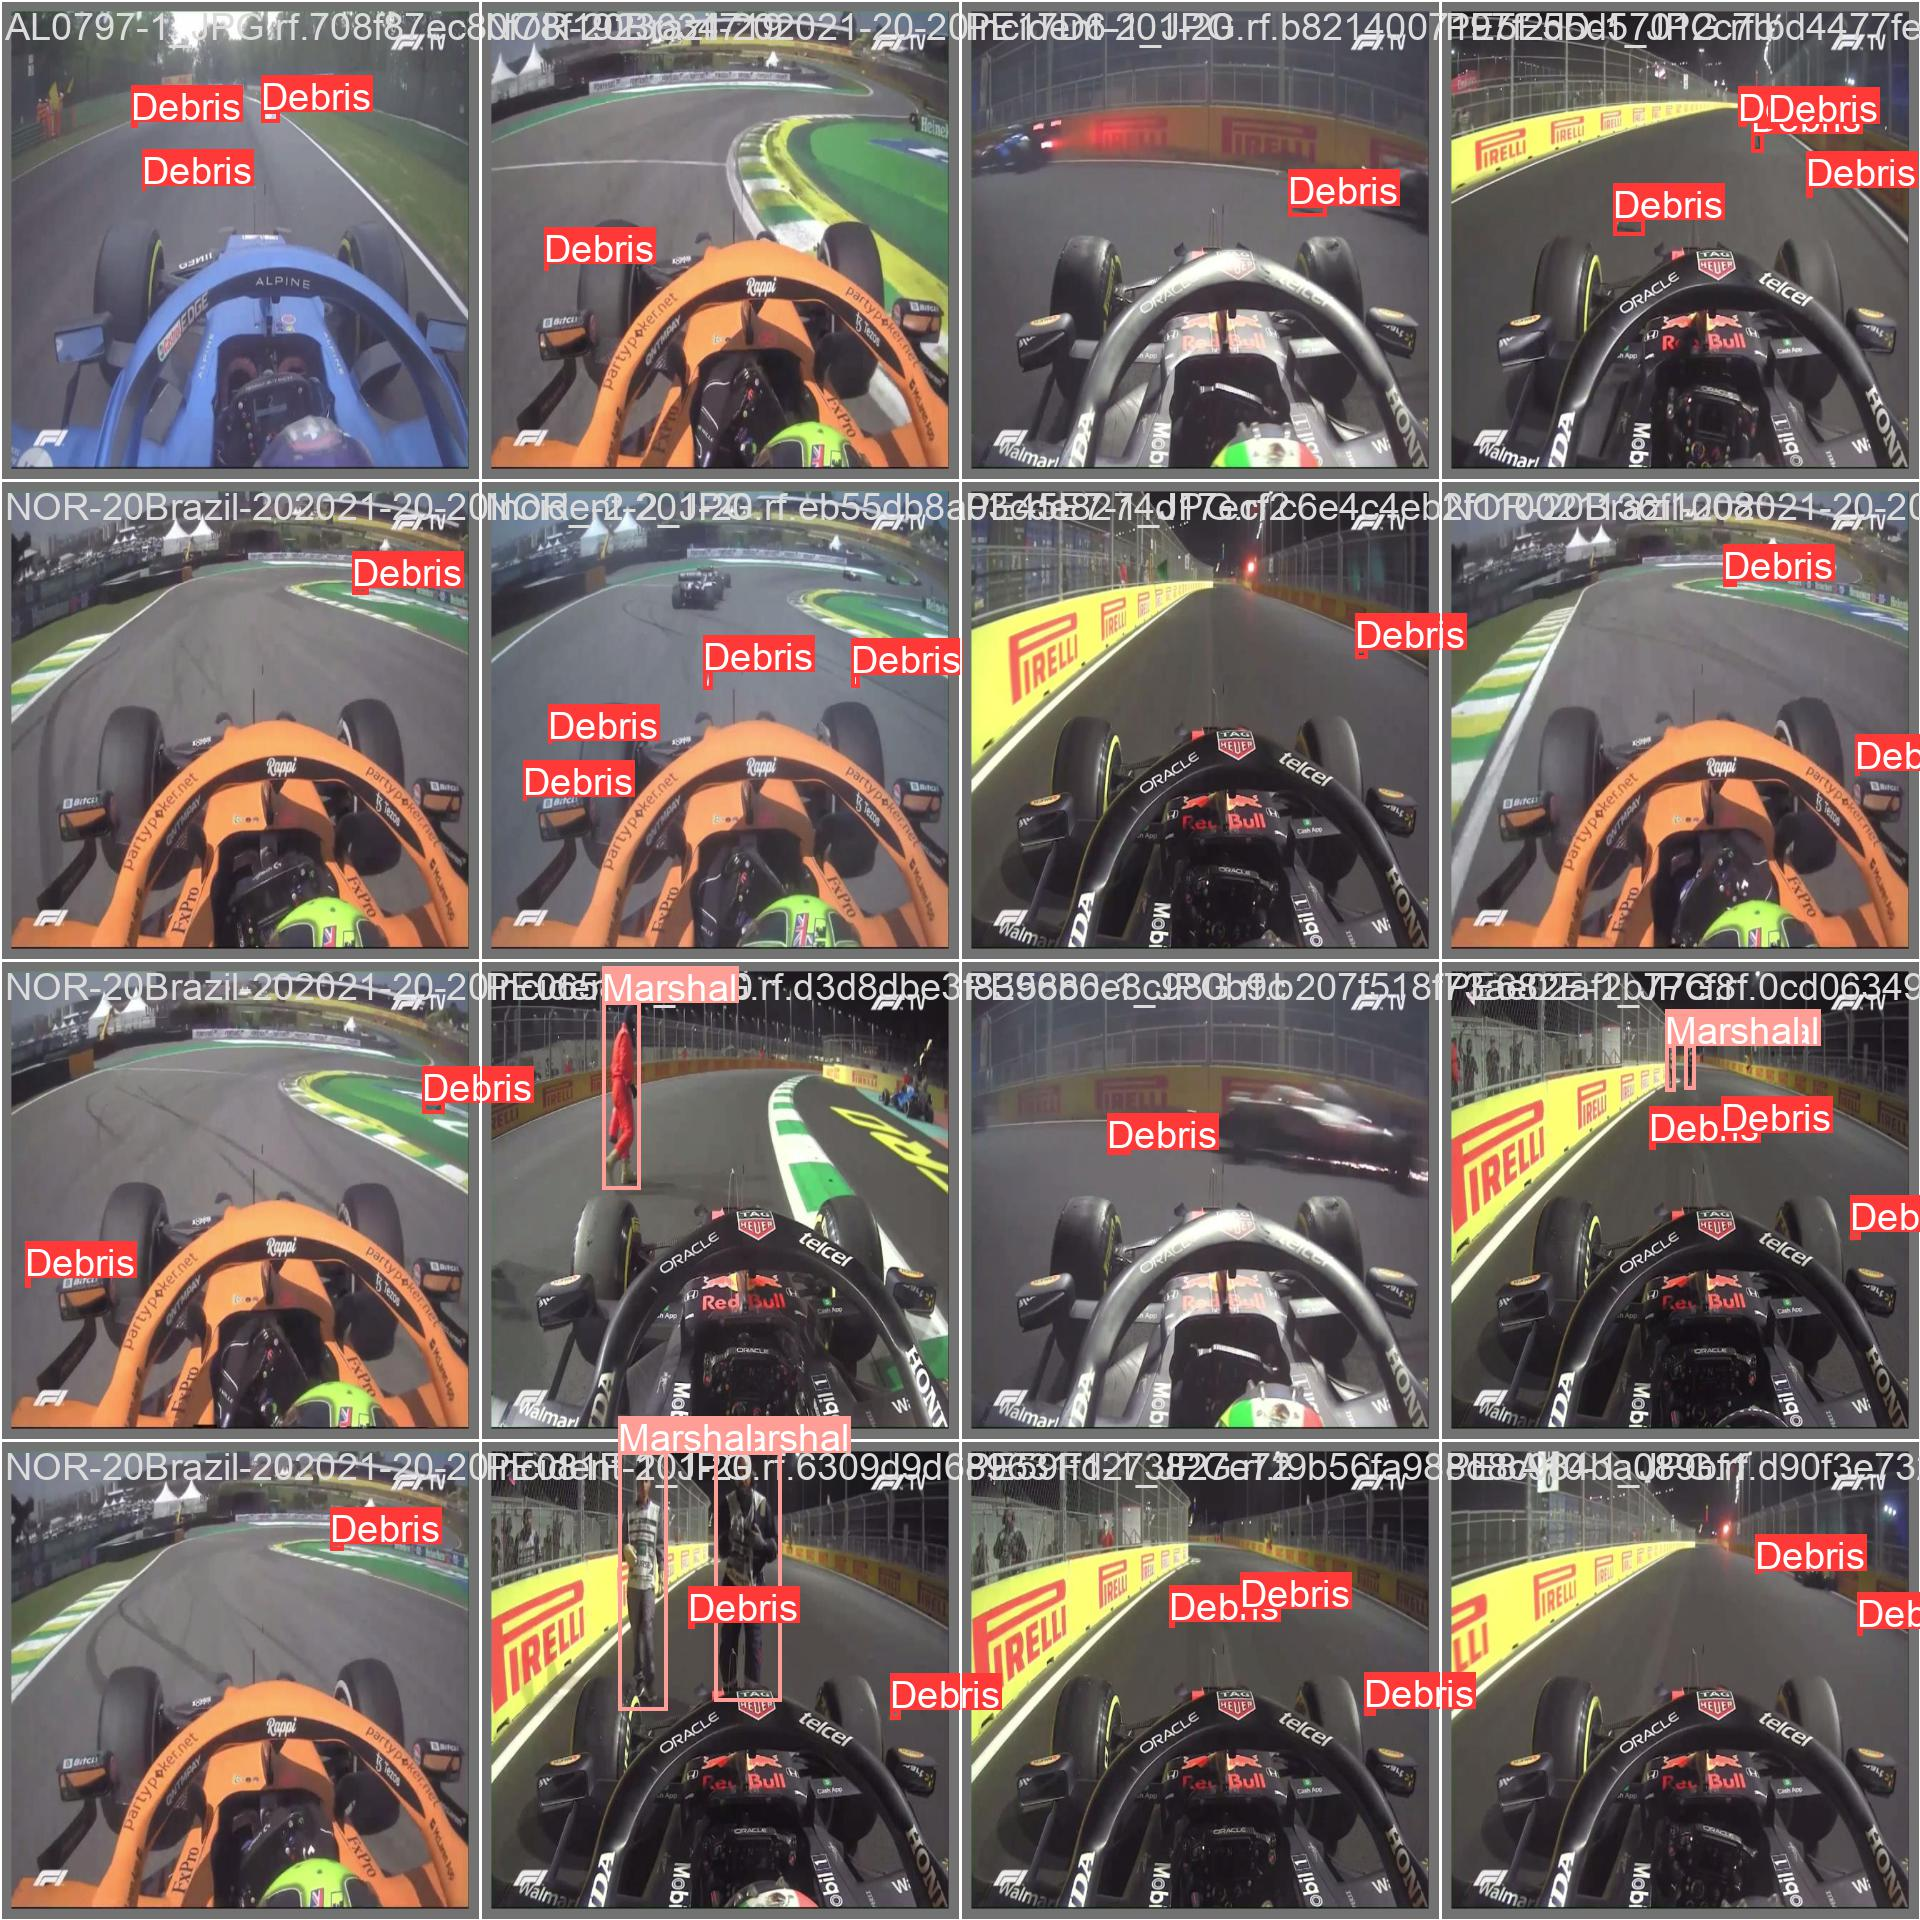

In [43]:
Image('/content/runs/detect/val' + str(n_trials+3) + '/val_batch0_labels.jpg', width=600)

Inference Example

Original Image


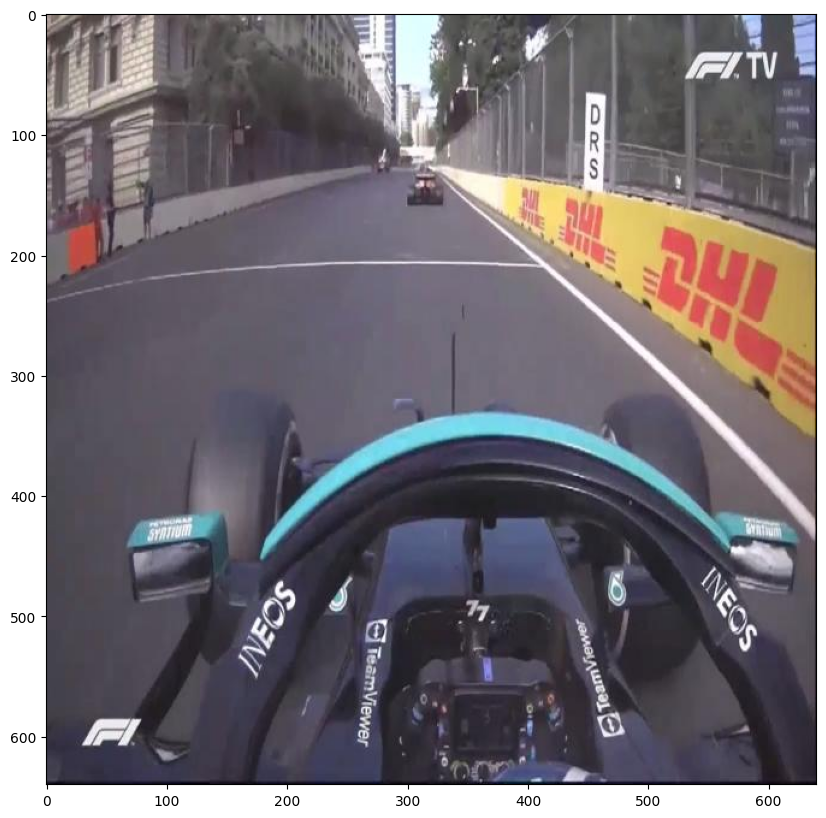


0: 640x640 3 Marshals, 1 Recovery Vehicle, 12.9ms
Speed: 0.9ms preprocess, 12.9ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


Predictions


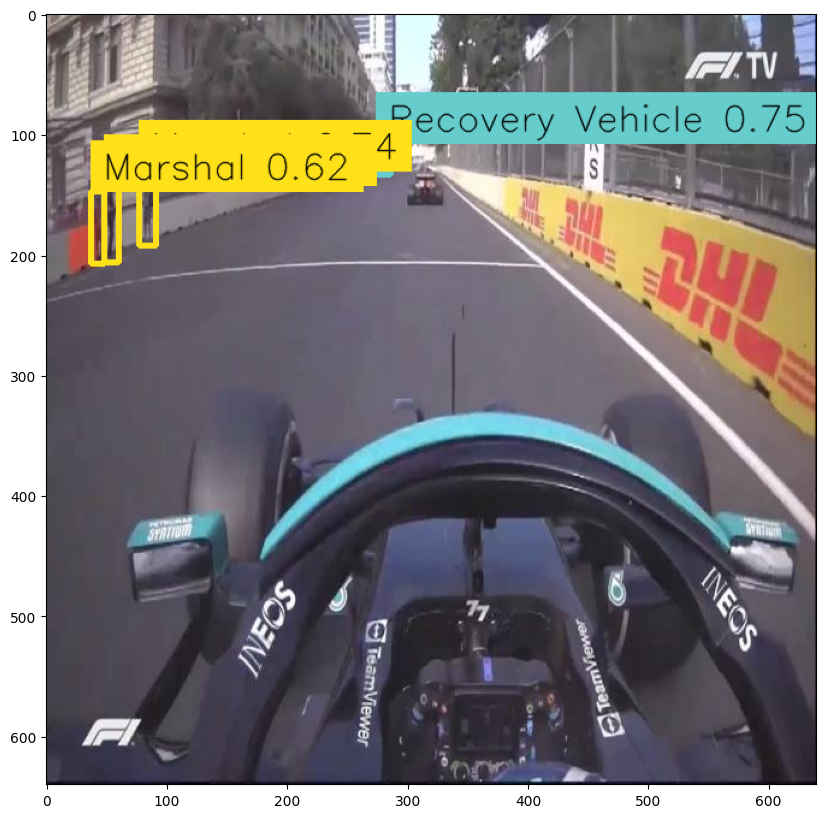

In [44]:
CLASS_NAMES_DICT = model.model.names
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.5

# Select random image from validation dataset
dir = "/content/Debris-Detection-Dataset-1/valid/images"
image_path = os.path.join(dir, random.choice(os.listdir(dir)))
image = cv2.imread(image_path)

# Display the selected random image
print('Original Image')
%matplotlib inline  
sv.show_frame_in_notebook(image, (10, 10))

# Tool used to annotate objects
box_annotator = BoxAnnotator(color=ColorPalette.from_hex(['#e6194b', '#ffe119', '#66cccc']), thickness=4, text_thickness=1, text_scale=1)

# Make predictions
results = model_finetuned(image, iou=IOU_TRESHOLD, conf=CONFIDENCE_TRESHOLD)

# Extract predictions 
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)

# Format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]

# Annotate the frame with the models detections
image = box_annotator.annotate(image, detections=detections, labels=labels)

# Display image with the models detections
print('Predictions')
%matplotlib inline  
sv.show_frame_in_notebook(image, (10, 10))